## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data, plot_ppds

import numpy as np
import torch
from torch.optim import SGD
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import time
from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# # Load the dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
# data = pd.read_excel(url)

# # The last two columns are the target variables (Heating Load and Cooling Load)
# X = data.iloc[:, :-2].values  # Covariates
# y = data.iloc[:, -2].values  # Heating Load
# dataset = 'energy'

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
dataset = 'wine'

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized] 

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

## Case 1: Analytical attack - Max disruption

In [7]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [8]:
def kl_div(mu_n, lam_n, sigma2, x, x_adv):
    sigma2_A = x_adv.T @ torch.inverse(lam_n) @ x_adv + sigma2
    mu_A = x_adv.T @ mu_n
    sigma2_D = x.T @ torch.inverse(lam_n) @ x + sigma2
    mu_D = x.T @ mu_n
    kl = 0.5 * (torch.log(sigma2_A / sigma2_D) + (sigma2_D + (mu_D - mu_A)**2) / sigma2_A - 1)
    return kl

In [9]:
# kl maximization to find adversarial attacked to a trained model
def kl_maximization(model, x, lr=0.01, n_iter=100, epsilon=.3):
    x_adv_values = []
    kl_values = []
    
    mu_n = model.mu
    lam_n = model.lam
    sigma2 = model.sigma2
    x_adv = (x + torch.randn_like(x) * 0.001).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = SGD([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
        kl.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        kl_values.append(-kl.detach().item())

    return x_adv.detach(), x_adv_values, kl_values 

In [10]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values, kl_values = kl_maximization(model, x, epsilon=0.3)

Text(0, 0.5, 'KL Divergence')

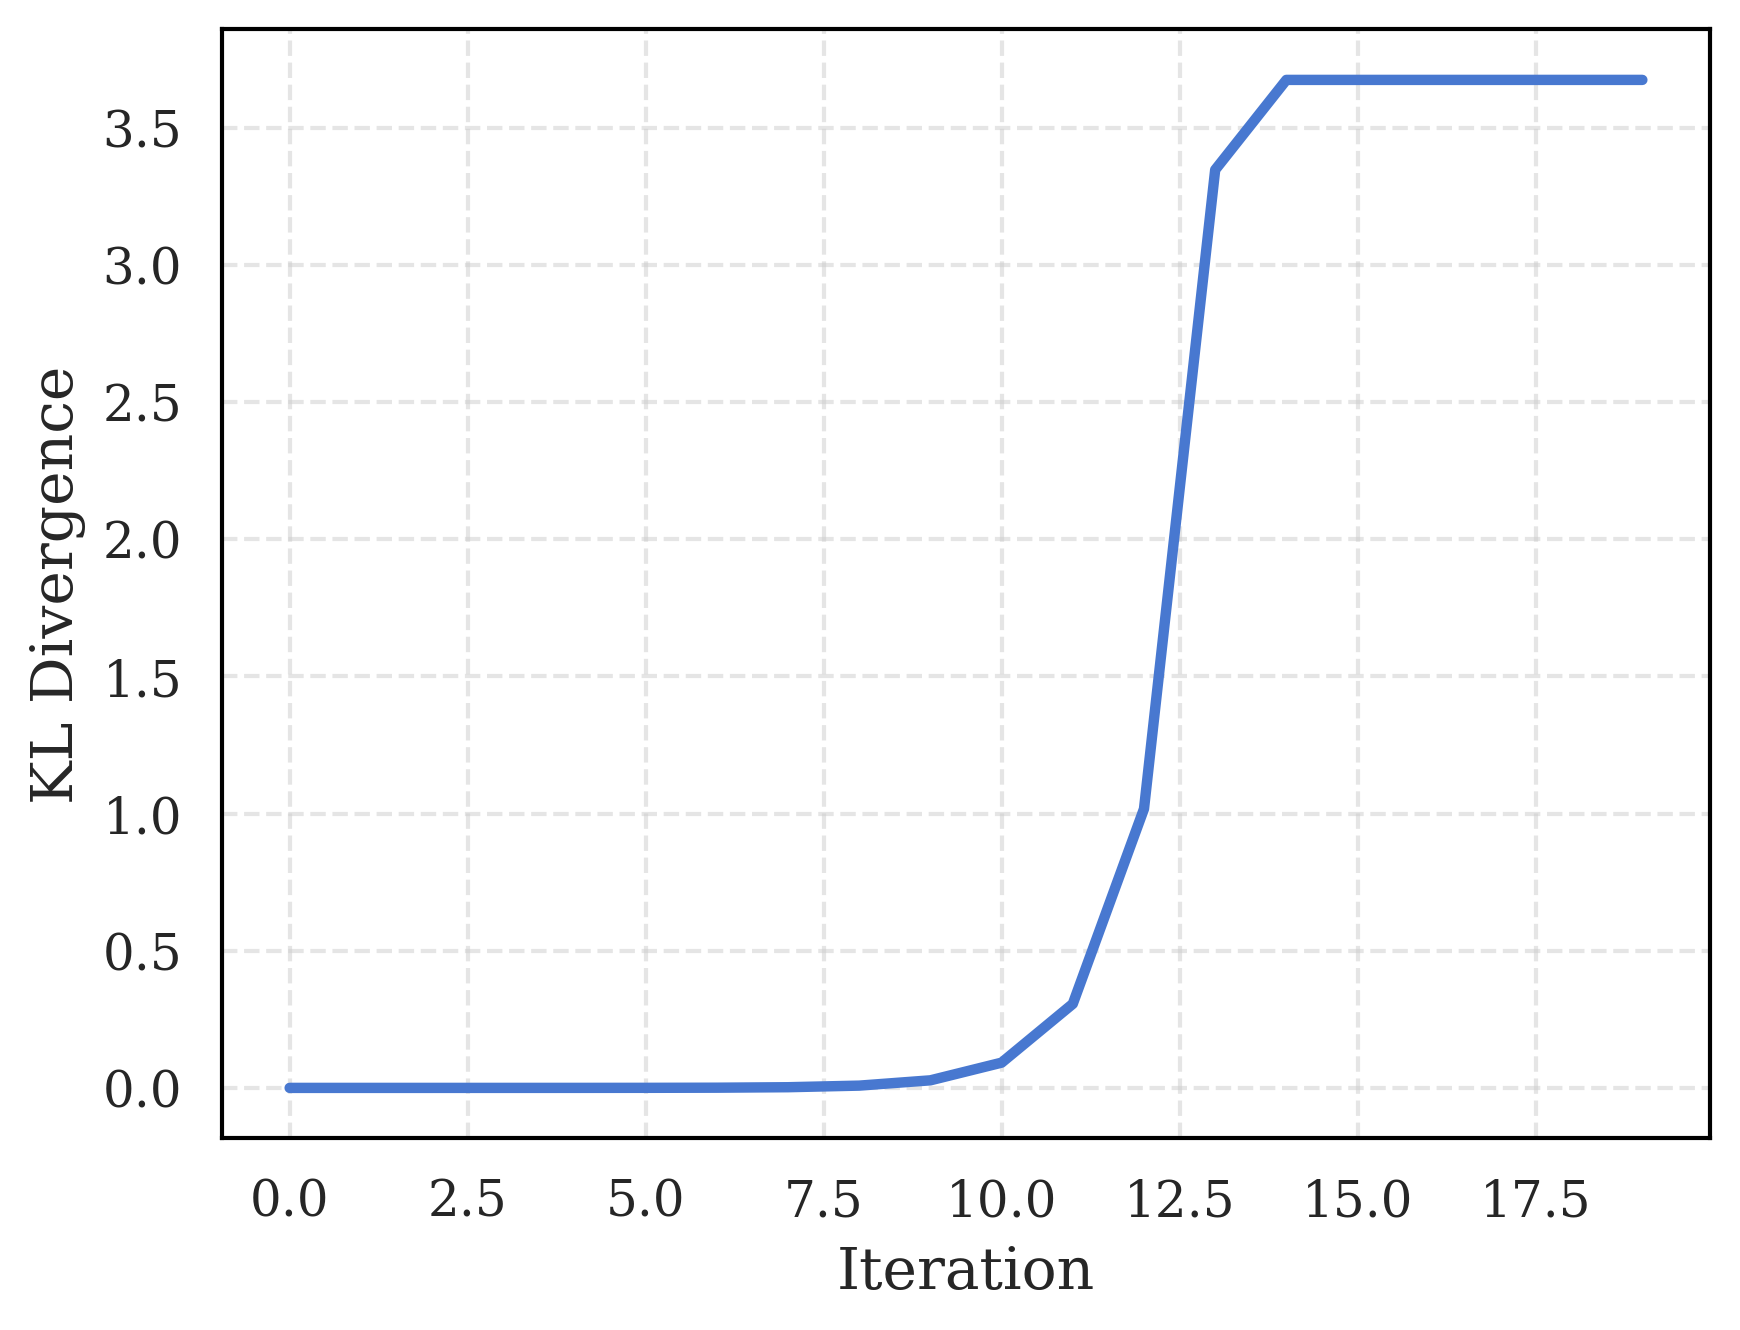

In [11]:
plt.plot(kl_values[:20])
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

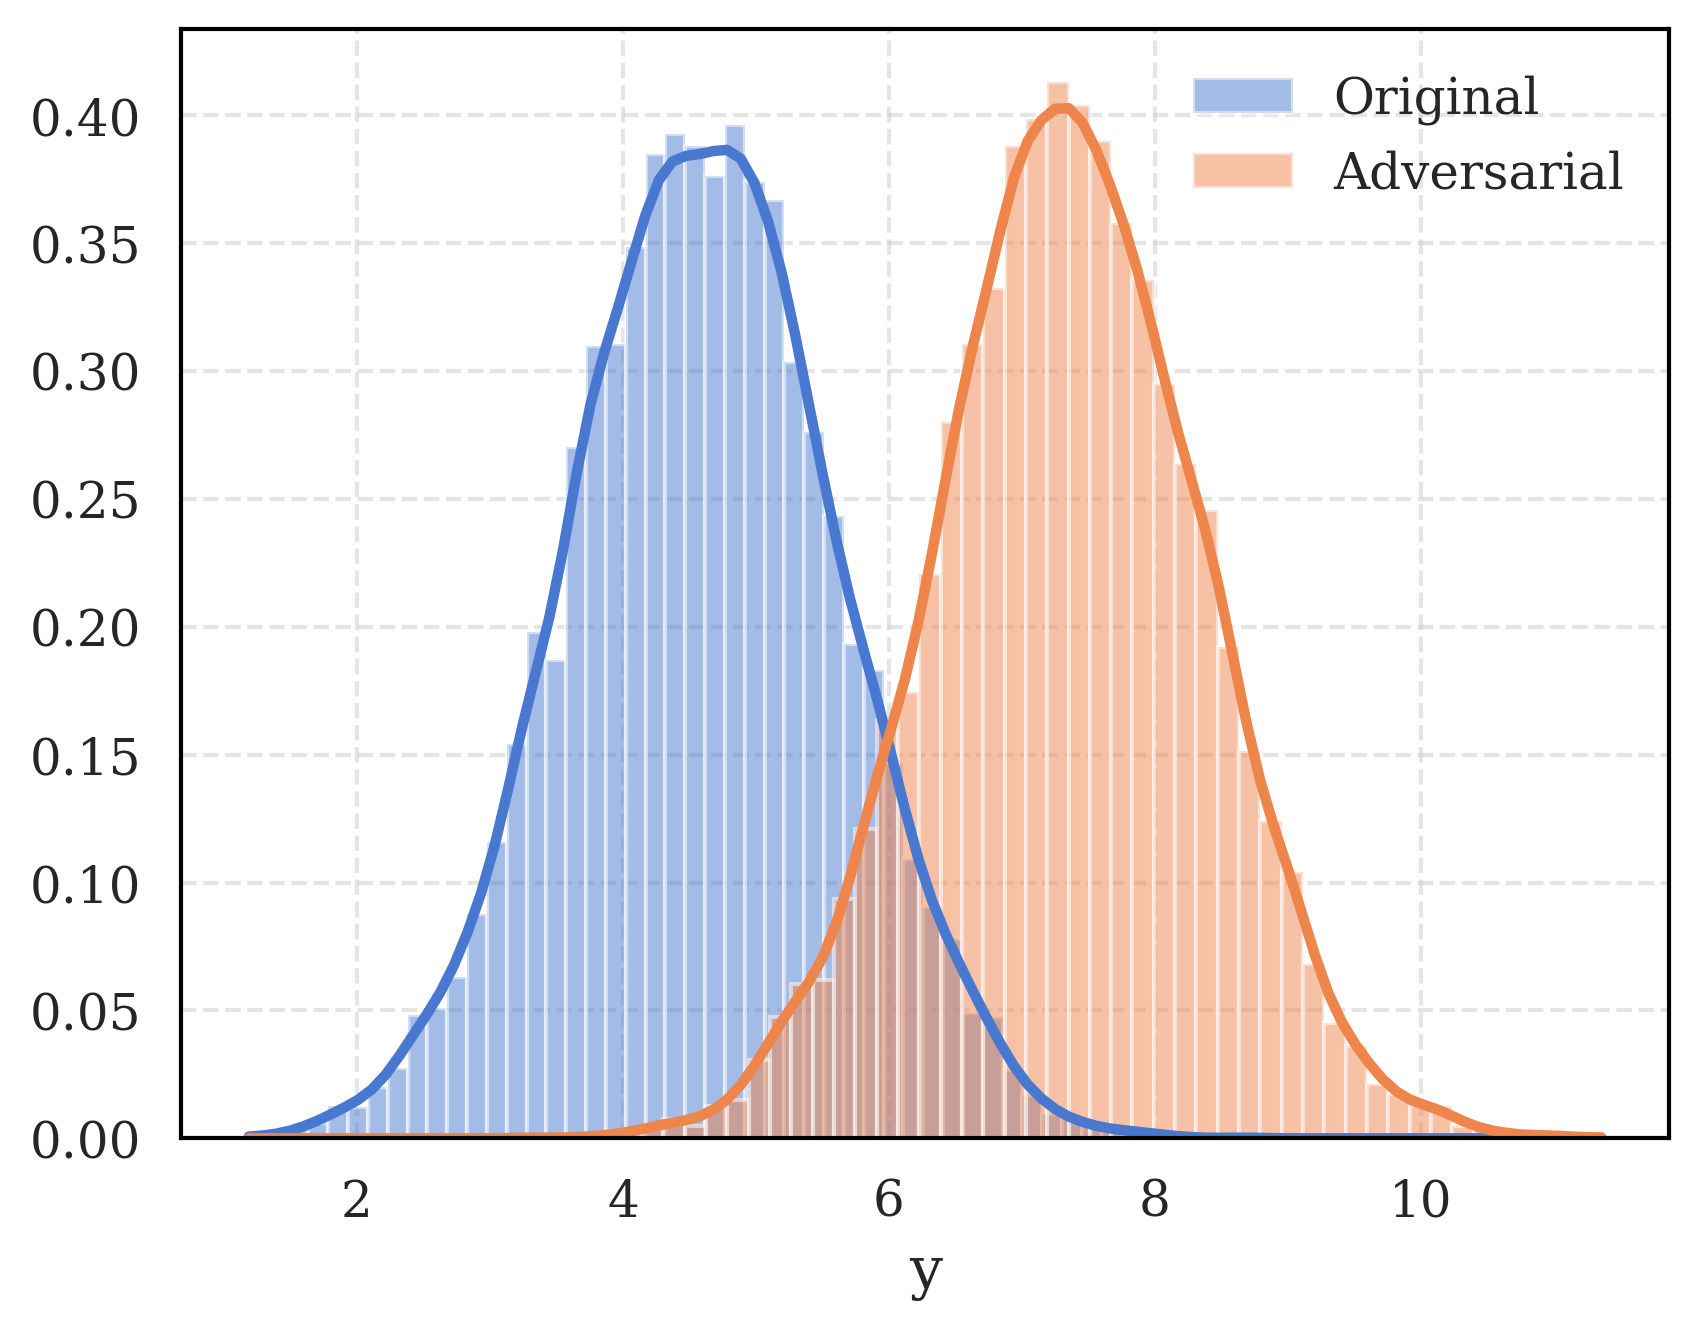

In [12]:
plot_ppds(model, x, x_adv_distr)

Text(0, 0.5, 'KL Divergence')

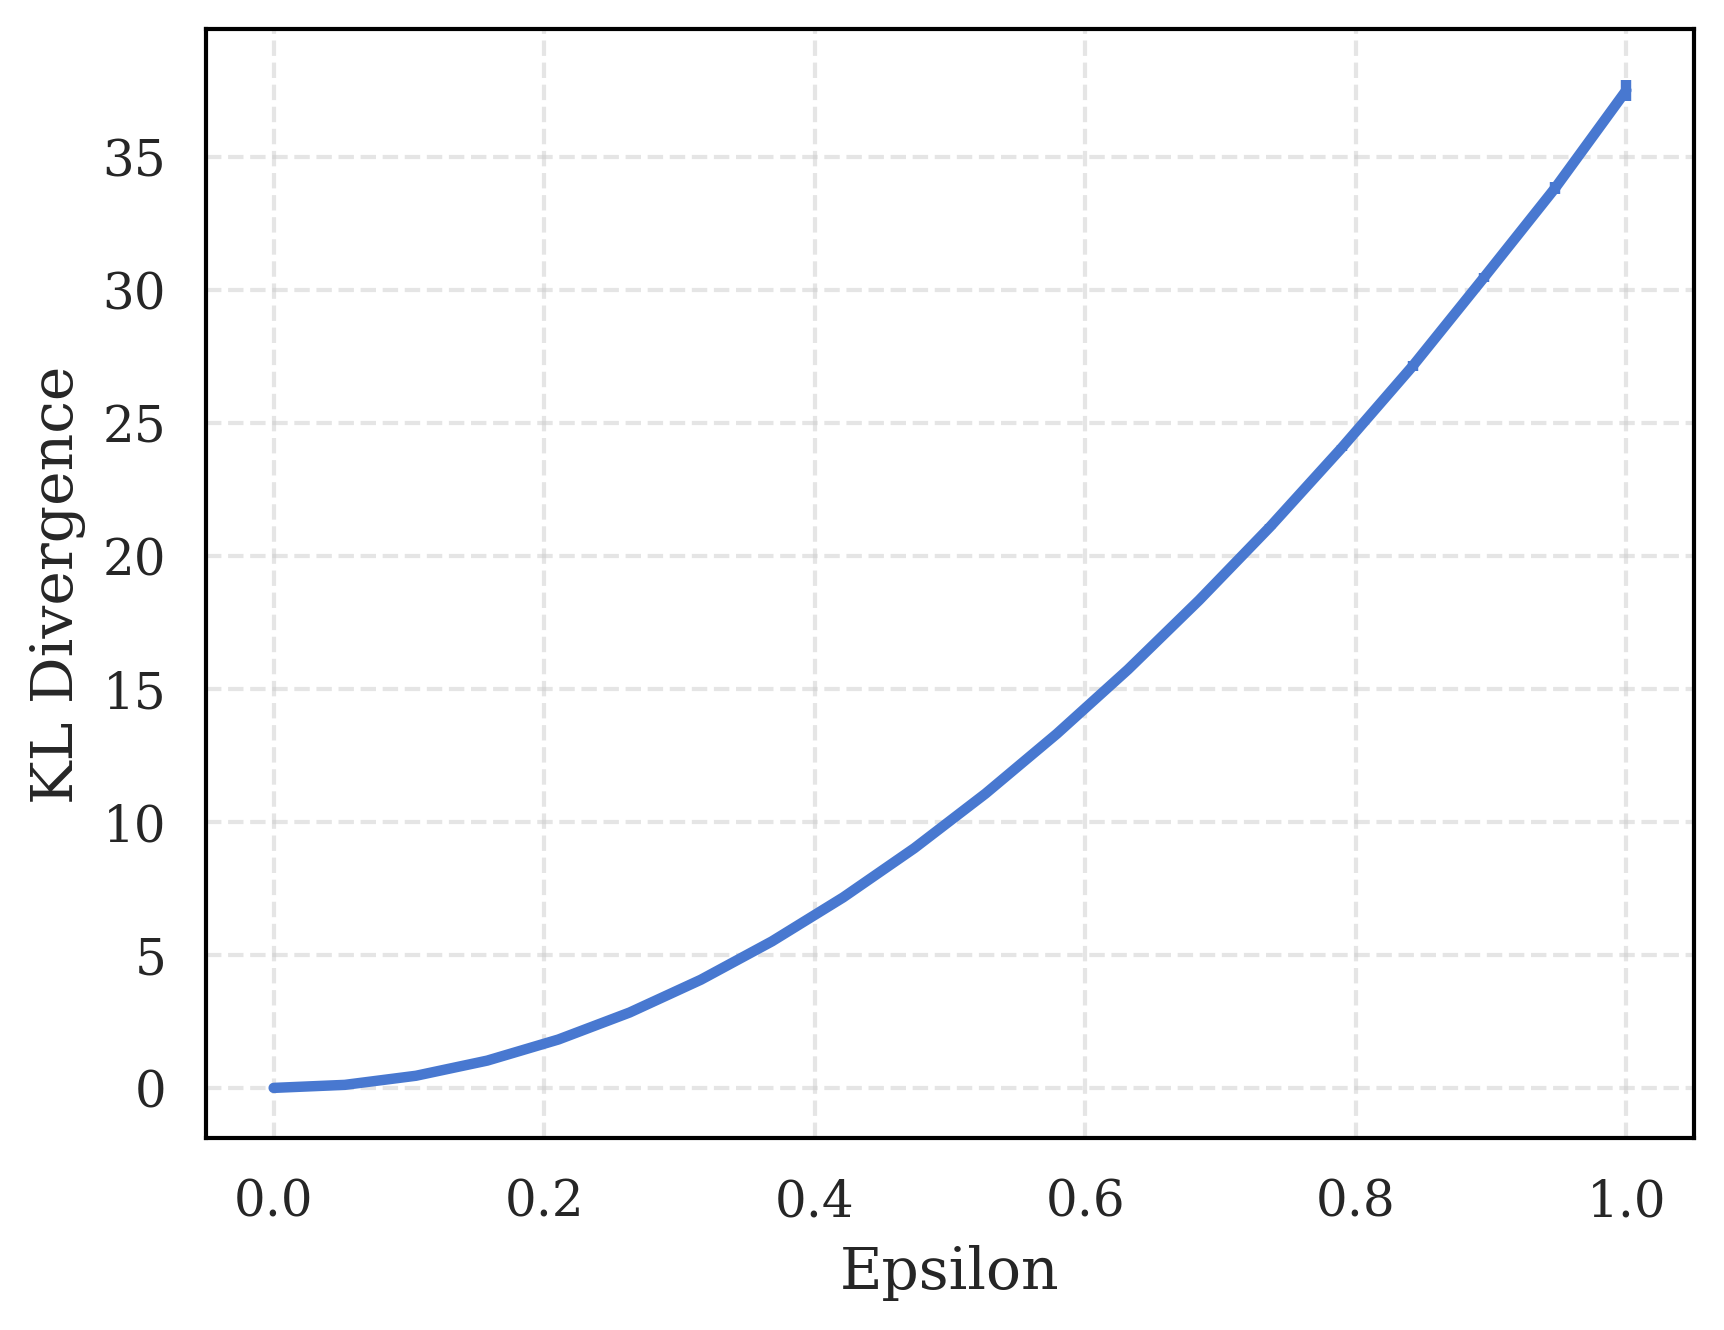

In [13]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

kl_alls = []
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    kl_values = []
    for epsilon in epsilons:
        x_adv_distr, _, kl = kl_maximization(model, x, epsilon=epsilon)
        kl_values.append(kl[-1])
    kl_alls.append(kl_values)

# std as error bars
plt.errorbar(epsilons, np.mean(kl_alls, axis=0), yerr=2*np.std(kl_alls, axis=0))
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

## Case 2: SGD attack

### Attack definition

In [14]:
# Function pi(y | x, gamma)
def pi(y, x, gamma):
    return torch.distributions.normal.Normal(x.T @ gamma[0], gamma[1]).log_prob(y).exp()

# Gradient of pi(y | x, gamma) with respect to x
# pi(y | x, gamma) is Normal(x.T @ beta, sigma2) with beta = gamma[0] and sigma2 = gamma[1]
def grad_pi(y, x, gamma): 
    distr = torch.distributions.normal.Normal(x.T @ gamma[0], gamma[1])
    prob = distr.log_prob(y).exp()
    grad = (y - x.T @ gamma[0]) / gamma[1] * prob * gamma[0]
    return grad


In [15]:
# g_{x, M}(y)
def g_x_M(y, x, gamma_samples): 
    # betas and sigmas shape: (D, M) and (1, M)
    grad_pi_vals = grad_pi(y, x, gamma_samples) 
    pi_vals = pi(y, x, gamma_samples) 
    numerator = torch.mean(grad_pi_vals, dim=1, keepdim=True)  # Promedio sobre M (segunda dimensión)
    denominator = torch.mean(pi_vals, dim=1)  # Promedio sobre M (segunda dimensión)
    return numerator / denominator  # not - since max disruption problem

In [16]:
# Compute Δg_{x, l}(y)
def delta_g_x_l(y, x, l, model, M_sequence):
    M_l = M_sequence[l]
    M_l_minus_1 = M_sequence[l-1] if l > 0 else 0
    gamma_samples_l = model.sample_posterior_distribution(M_l)
    
    # using the same samples for both terms in the difference
    gamma_samples_l_minus_1_a = [gamma_samples_l[0][:, :M_l_minus_1], gamma_samples_l[1][:, :M_l_minus_1]]
    gamma_samples_l_minus_1_b = [gamma_samples_l[0][:, M_l_minus_1:], gamma_samples_l[1][:, M_l_minus_1:]]

    g_l = g_x_M(y, x, gamma_samples_l)
    g_l_minus_1_a = g_x_M(y, x, gamma_samples_l_minus_1_a) if l > 0 else 0
    g_l_minus_1_b = g_x_M(y, x, gamma_samples_l_minus_1_b) if l > 0 else 0
    return g_l - (g_l_minus_1_a + g_l_minus_1_b) / 2

In [17]:
# Estimate the gradient using MLMC in parallel with joblib
def mlmc_gradient_estimator(y, x, R, model, M0=1, tau=1., n_jobs=50):
    # Define sequence M_l
    M_sequence = [M0*2**l for l in range(100)]

    # Define weights ω_l
    omega = [2**(-tau * l) for l in range(len(M_sequence))]
    omega = np.array(omega)
    omega /= omega.sum()  # Normalize

    l_indices = np.random.choice(len(M_sequence), size=R, p=omega)
    
    estimates = Parallel(n_jobs=n_jobs)(
        delayed(delta_g_x_l)(y, x, l, model, M_sequence) for l in l_indices
    )  
    estimates = [est / omega[l] for l, est in zip(l_indices, estimates)]
    return sum(estimates) / R

In [18]:
# Attack function to use the gradient estimator for maximum disruption
def mlmc_attack(model, x, appd=None, lr=0.01, n_iter=1000, epsilon=.1, R=100, early_stopping_patience=10):
    """
    Function to perform the attack using the MLMC gradient estimator.
    :param appd: Attacker predictive posterior distribution to approximate. If None -> Maximum disruption attack.
    """
    x_adv_values = []
    patience = 0
    # x_adv = (x + torch.randn_like(x) * 0.0001).clone().requires_grad_(True)  # add some noise to the input so kl is not zero
    x_adv = x.clone().requires_grad_(True)
    optimizer = SGD([x_adv], lr=lr)

    for it in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        if appd is None:
            y = model.sample_predictive_distribution(x, num_samples=1)
        else:
            y = appd.sample()
        start = time.time()
        if appd is None:
            x_adv.grad = mlmc_gradient_estimator(y, x_adv, R, model)
        else:
            x_adv.grad = - mlmc_gradient_estimator(y, x_adv, R, model)  # If appd is not None, we want to minimize the loss
        if time.time() - start > 2:
            print(f'Long gradient estimation time: {time.time() - start} for iteration {it}')
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())

        if it > 2 and np.linalg.norm(x_adv_values[-1] - x_adv_values[-2]) < 1e-3:
            patience += 1
            if patience >= early_stopping_patience:
                print(f'Early stopping at iteration {it}')
                break
        else:
            patience = 0

    return x_adv.detach(), x_adv_values

In [19]:
# Attack function to use the gradient estimator for maximum disruption
def fgsm_attack(model, x, appd=None, lr=0.01, n_iter=1000, epsilon=.1, R=100, early_stopping_patience=10):
    """
    Function to perform the FGSM attack using the MLMC gradient estimator.
    :param appd: Attacker predictive posterior distribution to approximate. If None -> Maximum disruption attack.
    """
    x_adv = x.clone().requires_grad_(True)
    optimizer = SGD([x_adv], lr=lr)

    x_adv.requires_grad = True
    optimizer.zero_grad()
    if appd is None:
        y = model.sample_predictive_distribution(x, num_samples=1)
    else:
        y = appd.sample()
    grad = mlmc_gradient_estimator(y, x_adv, R, model)
    if appd is None:
        x_adv.grad = grad.sign()
    else:
        x_adv.grad = - grad.sign()  # If appd is not None, we want to minimize the loss
        
    optimizer.step()
    x_adv.grad.zero_()
    
    with torch.no_grad():
        x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
        
    return x_adv.detach()

### Case 2a: NormalInverseGamma model

In [20]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([10]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


Long gradient estimation time: 4.651797771453857 for iteration 0
Long gradient estimation time: 2.6760003566741943 for iteration 156


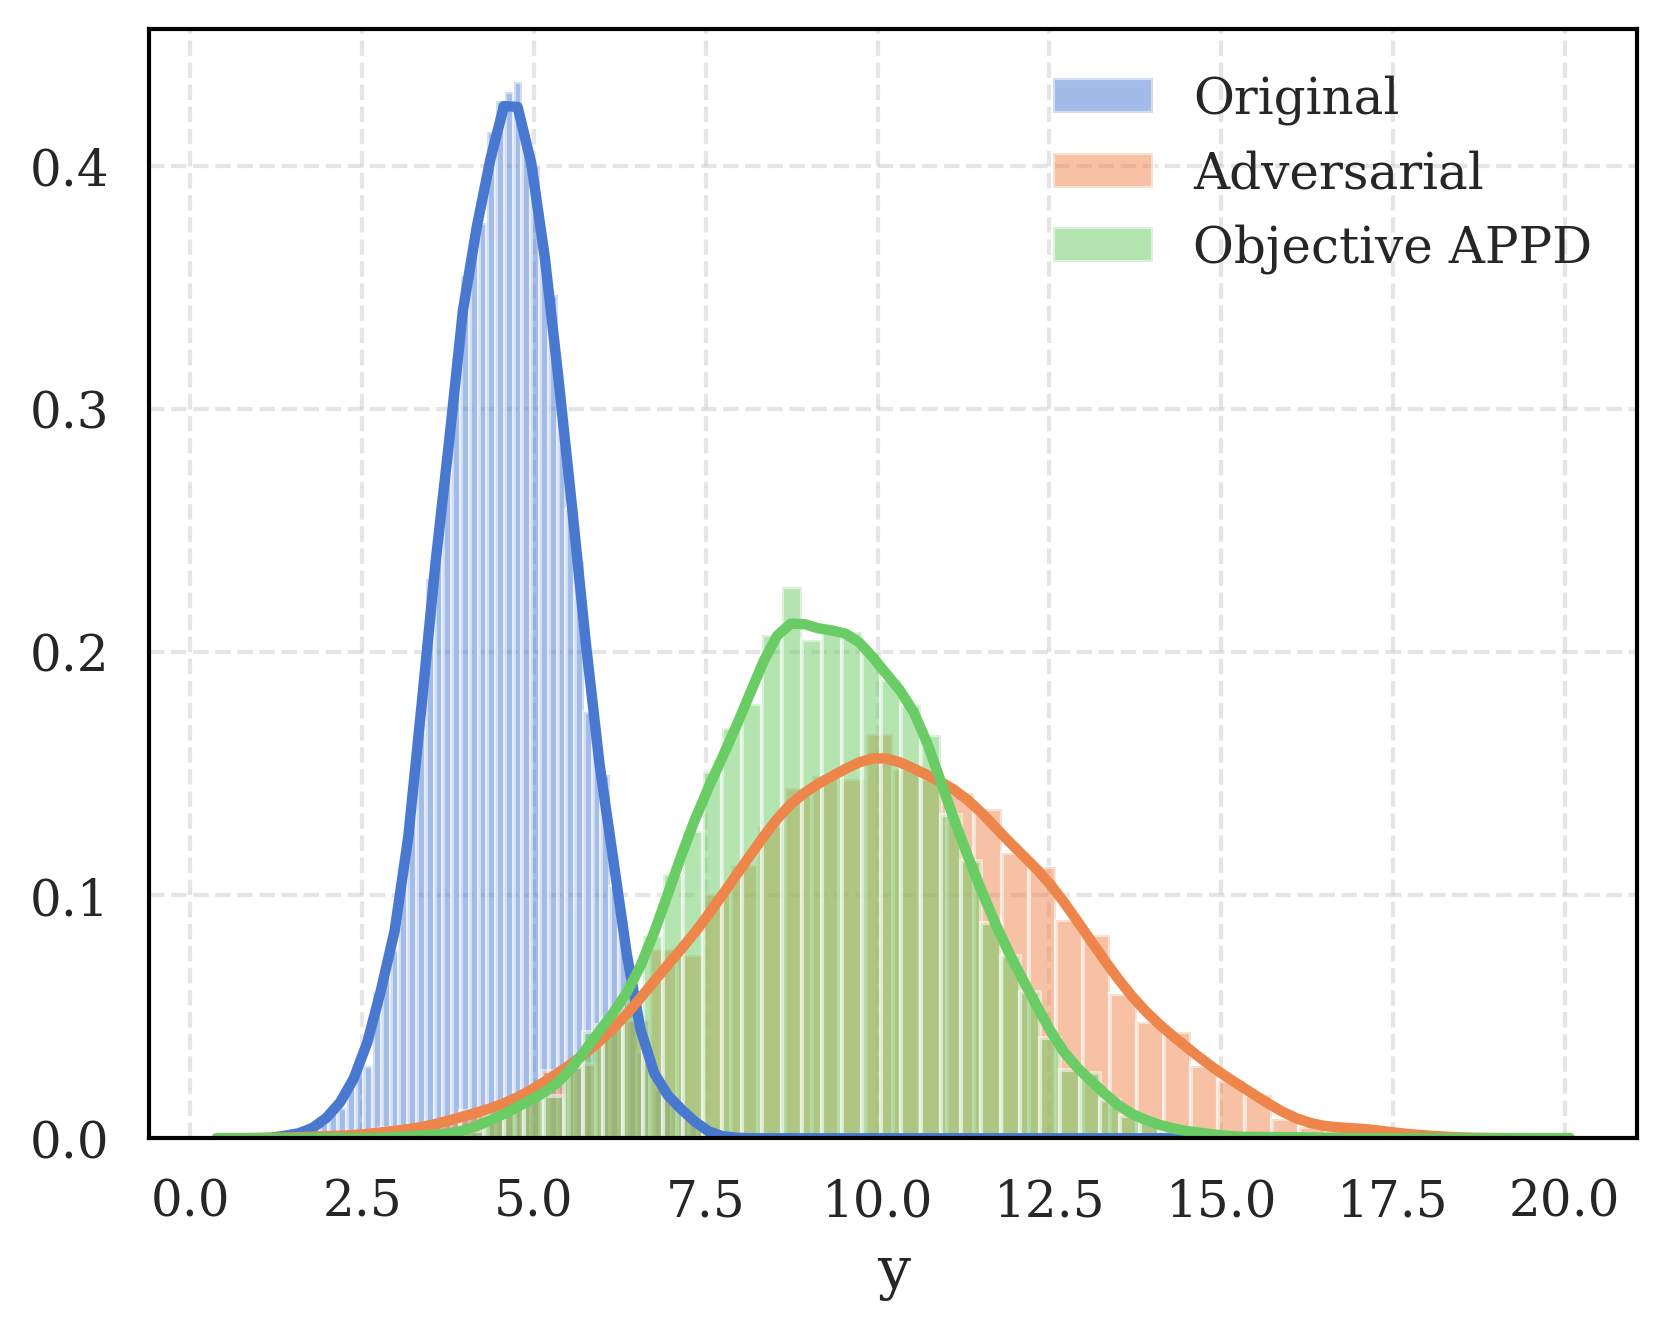

In [21]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=100, lr=0.01, n_iter=200)
plot_ppds(model, x, x_adv_distr, appd)

Long gradient estimation time: 2.7760233879089355 for iteration 10
Early stopping at iteration 13


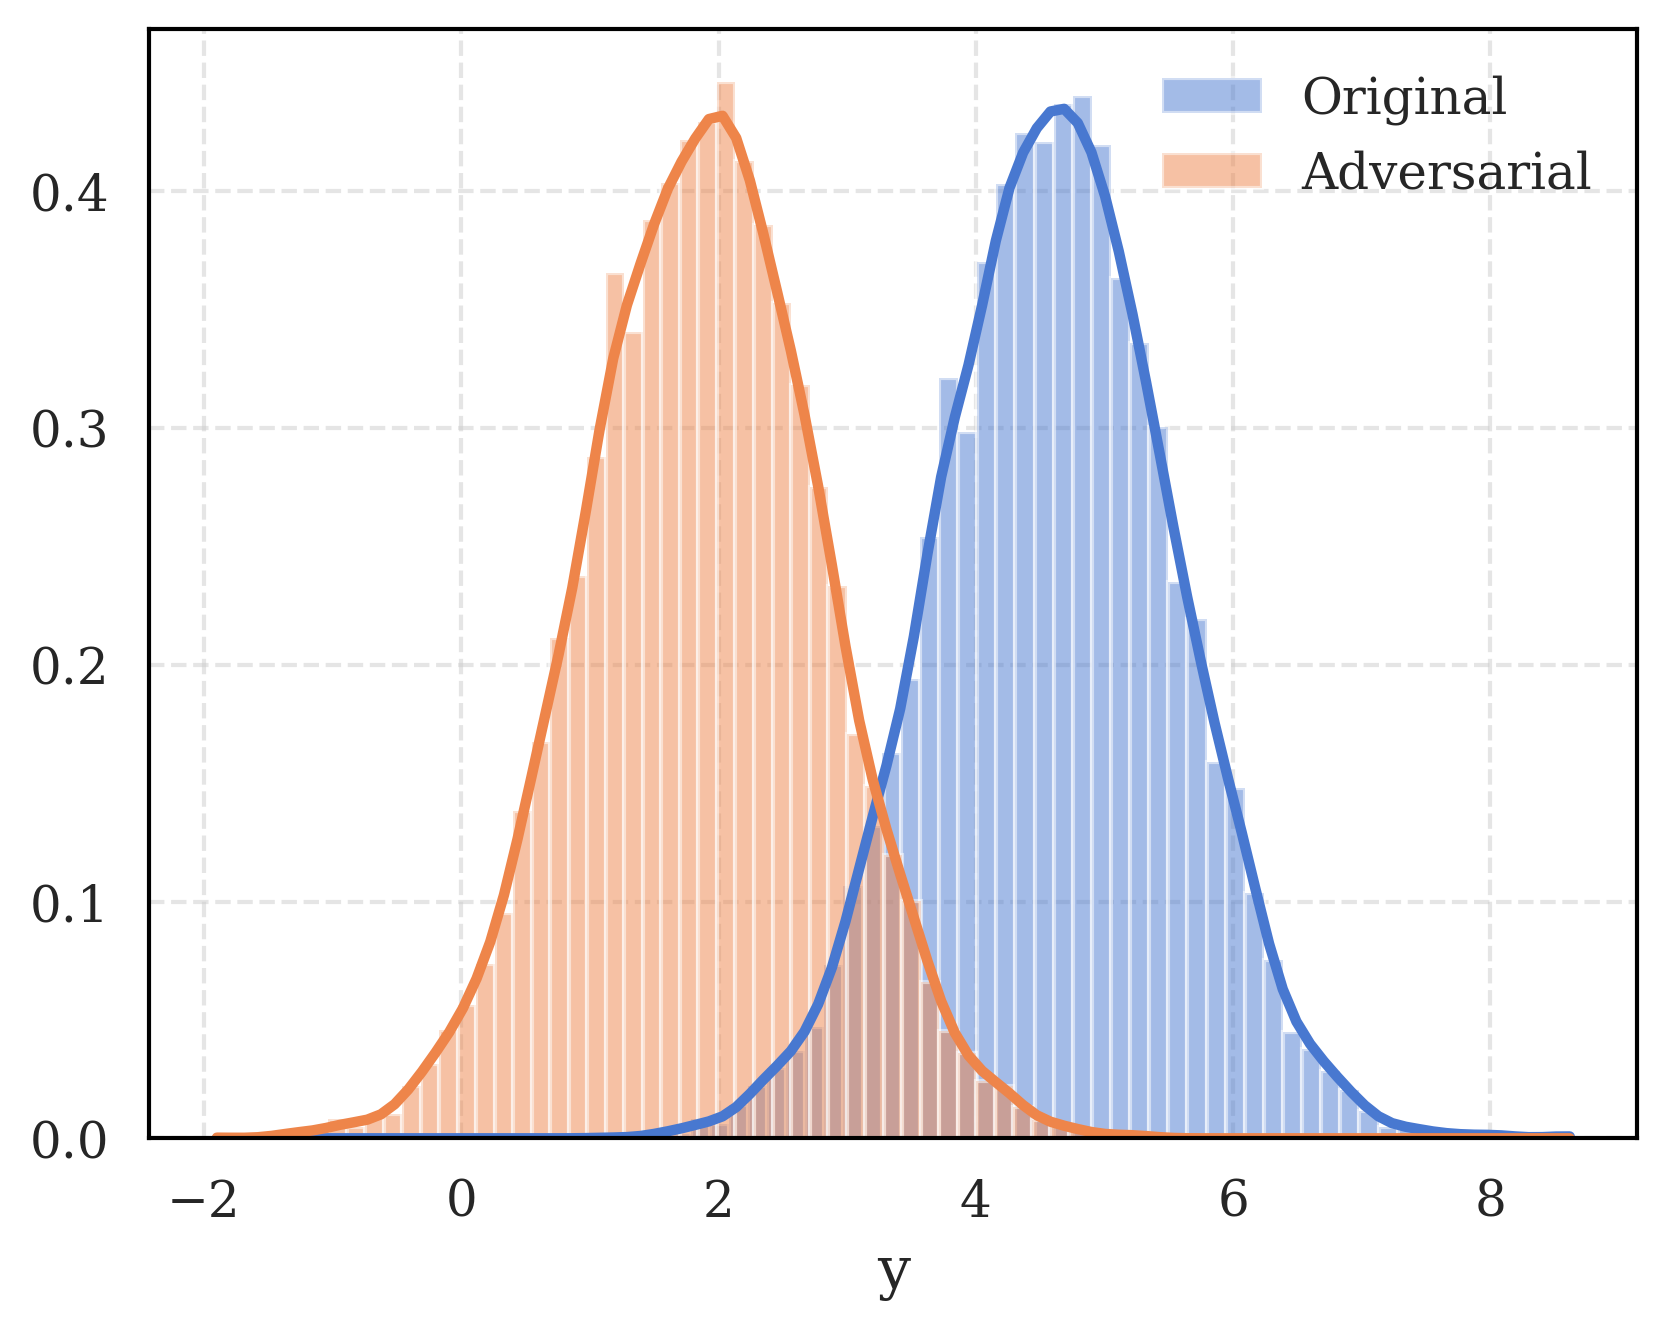

In [22]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=.3, R=100, lr=0.01, n_iter=200)
plot_ppds(model, x, x_adv_distr)

0
Early stopping at iteration 13
1
Early stopping at iteration 12
2
Early stopping at iteration 14
3
Early stopping at iteration 14
4
Early stopping at iteration 13
5
Early stopping at iteration 18
6
Early stopping at iteration 12
7
Early stopping at iteration 15
8
Early stopping at iteration 14
9
Early stopping at iteration 15


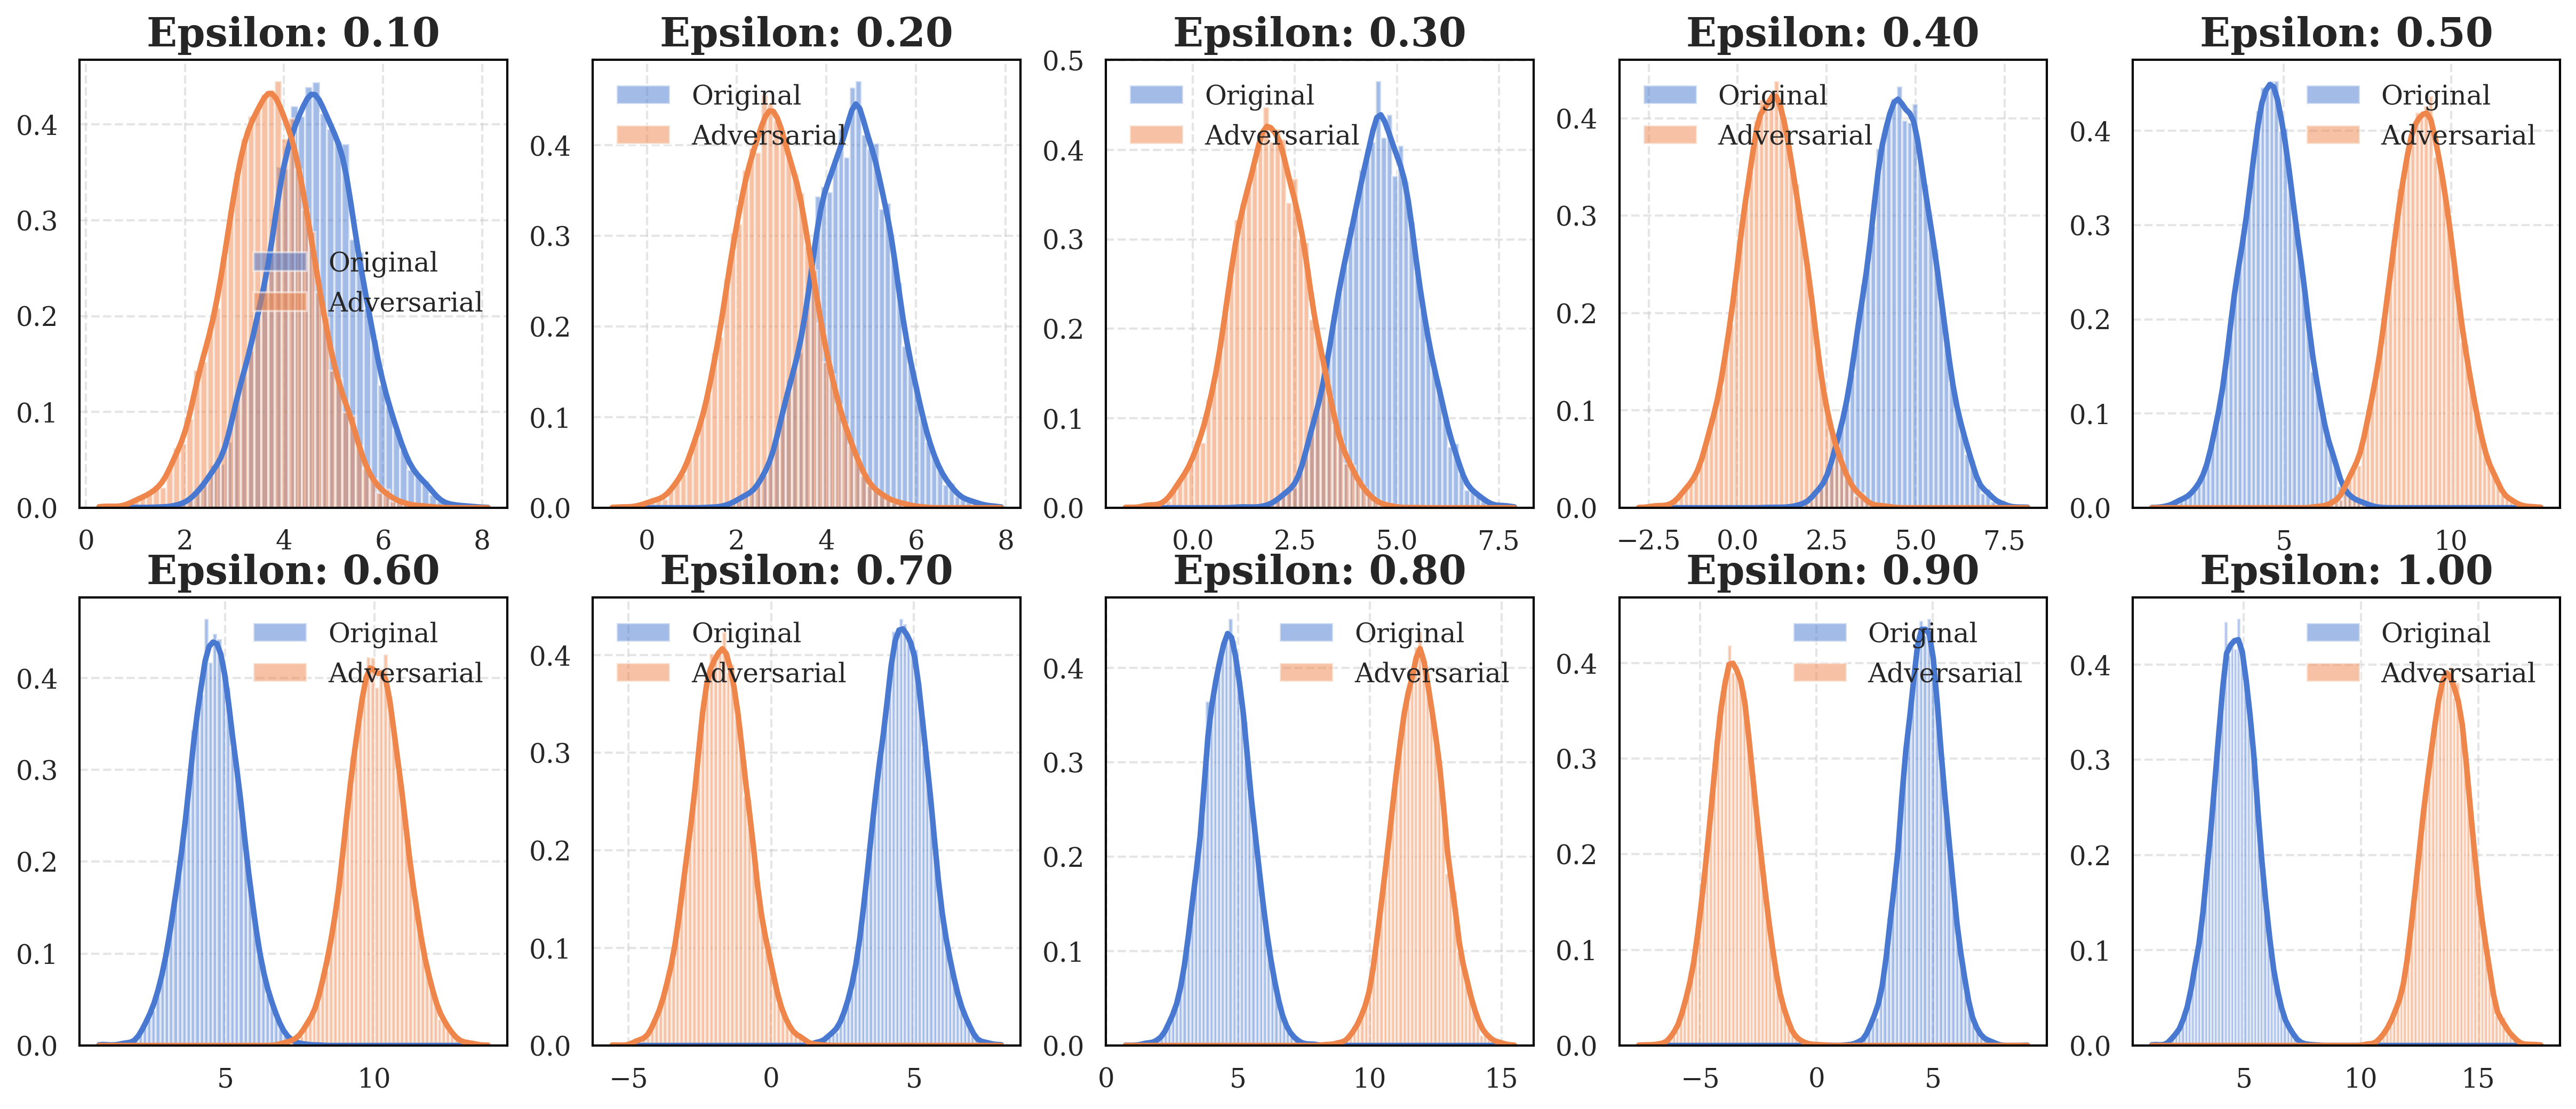

In [23]:
# Plot the histogram for 10 different epsilon values as subplots
epsilons = np.linspace(0.1, 1, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, epsilon in enumerate(epsilons):
    print(i)
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon)
    ax = axs[i // 5, i % 5]

    y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
    y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()

    kde = gaussian_kde(y_samples.T)
    kde_adv = gaussian_kde(y_adv_samples.T)

    ax.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
    ax.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

    ys = np.linspace(
        min(np.min(y_samples), np.min(y_adv_samples)), 
        max(np.max(y_samples), np.max(y_adv_samples)), 
        100)
    # plot with same color and label
    ax.plot(ys, kde(ys), color='C0')
    ax.plot(ys, kde_adv(ys), color='C1')
    ax.legend()

    ax.set_title(f'Epsilon: {epsilon:.2f}')

/tmp/ipykernel_2866162/1901980804.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)


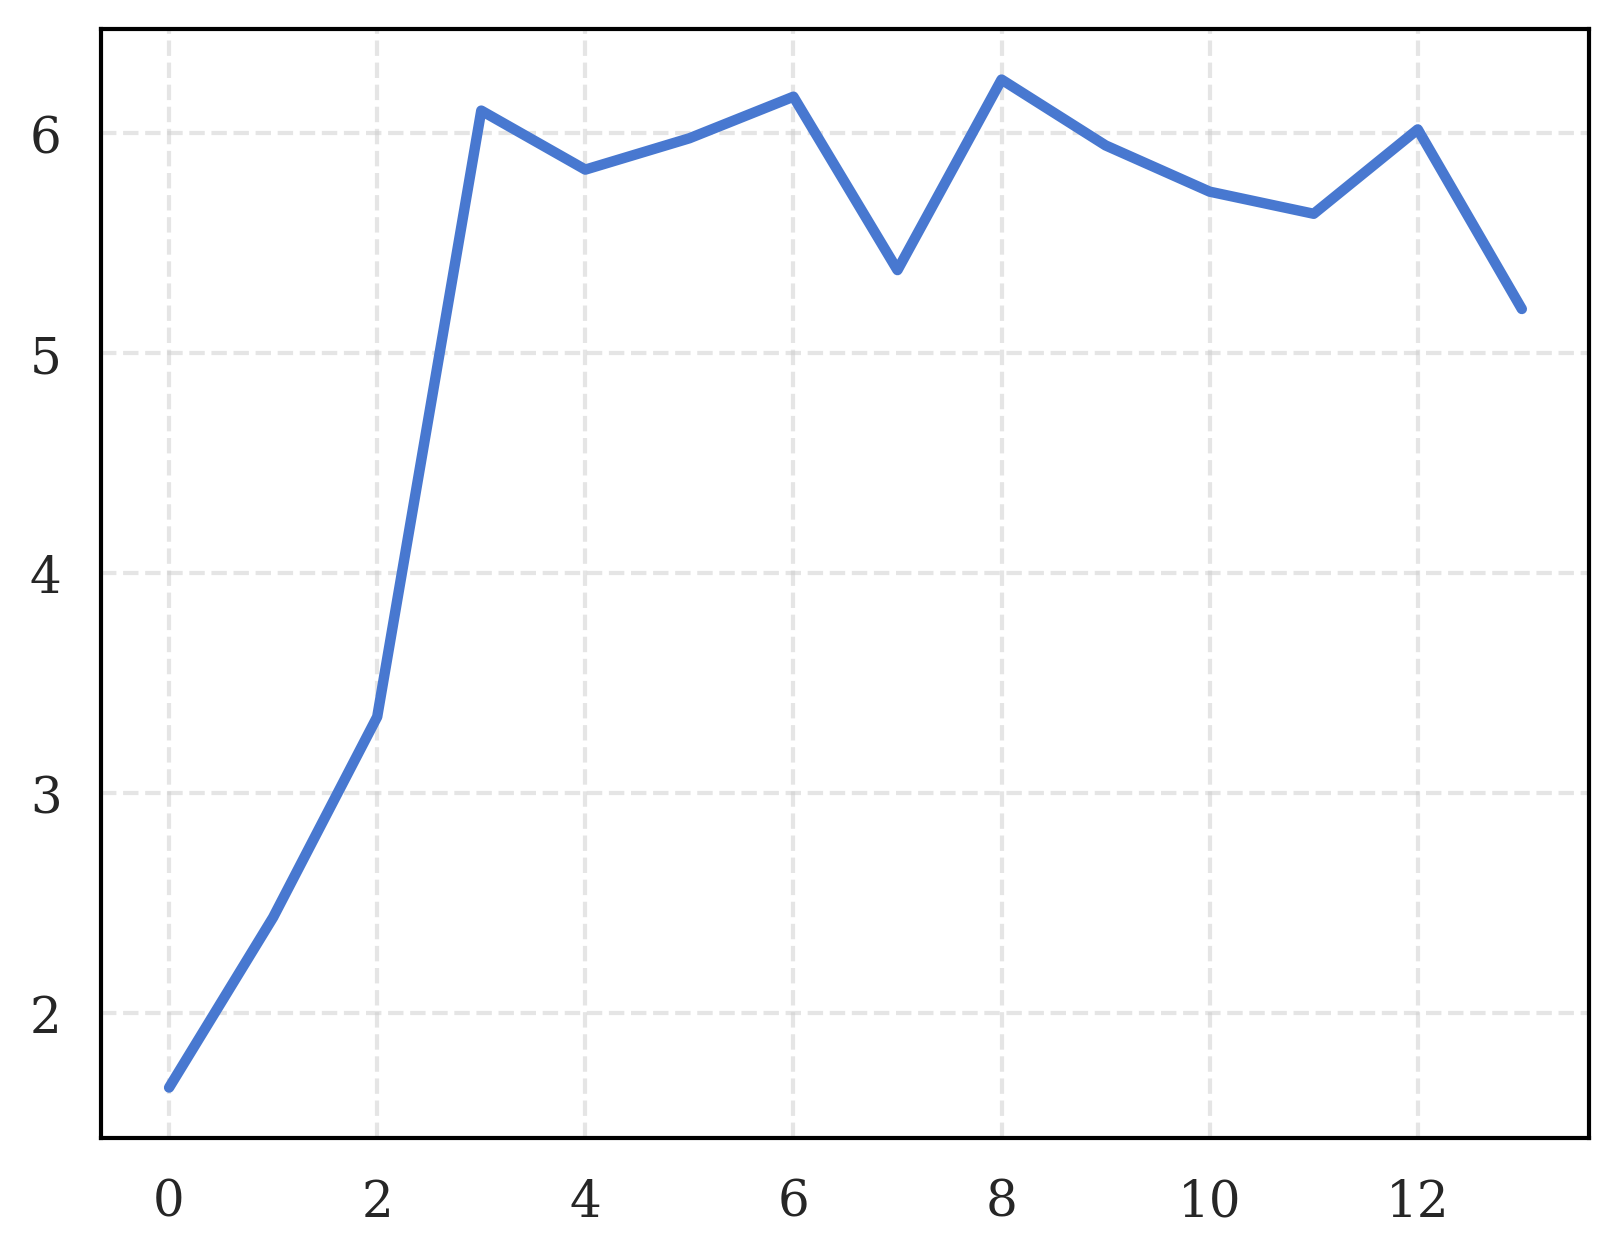

In [24]:
# Plot values evolution for the adversarial attack
kl_proxies = []
for x_adv in x_adv_values:
    y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)
    val = -torch.mean(torch.log(pi(y_samples, torch.tensor(x_adv, dtype=torch.float32), model.sample_posterior_distribution(100))))
    kl_proxies.append(val.item())

plt.plot(kl_proxies)

Long gradient estimation time: 2.044193983078003 for iteration 7
Long gradient estimation time: 4.146329402923584 for iteration 5
Early stopping at iteration 12
Long gradient estimation time: 2.4942052364349365 for iteration 9
Early stopping at iteration 12
Long gradient estimation time: 4.43986439704895 for iteration 7
Long gradient estimation time: 4.324664354324341 for iteration 8
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 18
Long gradient estimation time: 2.3668527603149414 for iteration 9
Early stopping at iteration 12
Long gradient estimation time: 2.4959661960601807 for iteration 13
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 14
Long gradient e

Text(0, 0.5, 'Proxy of KL Divergence')

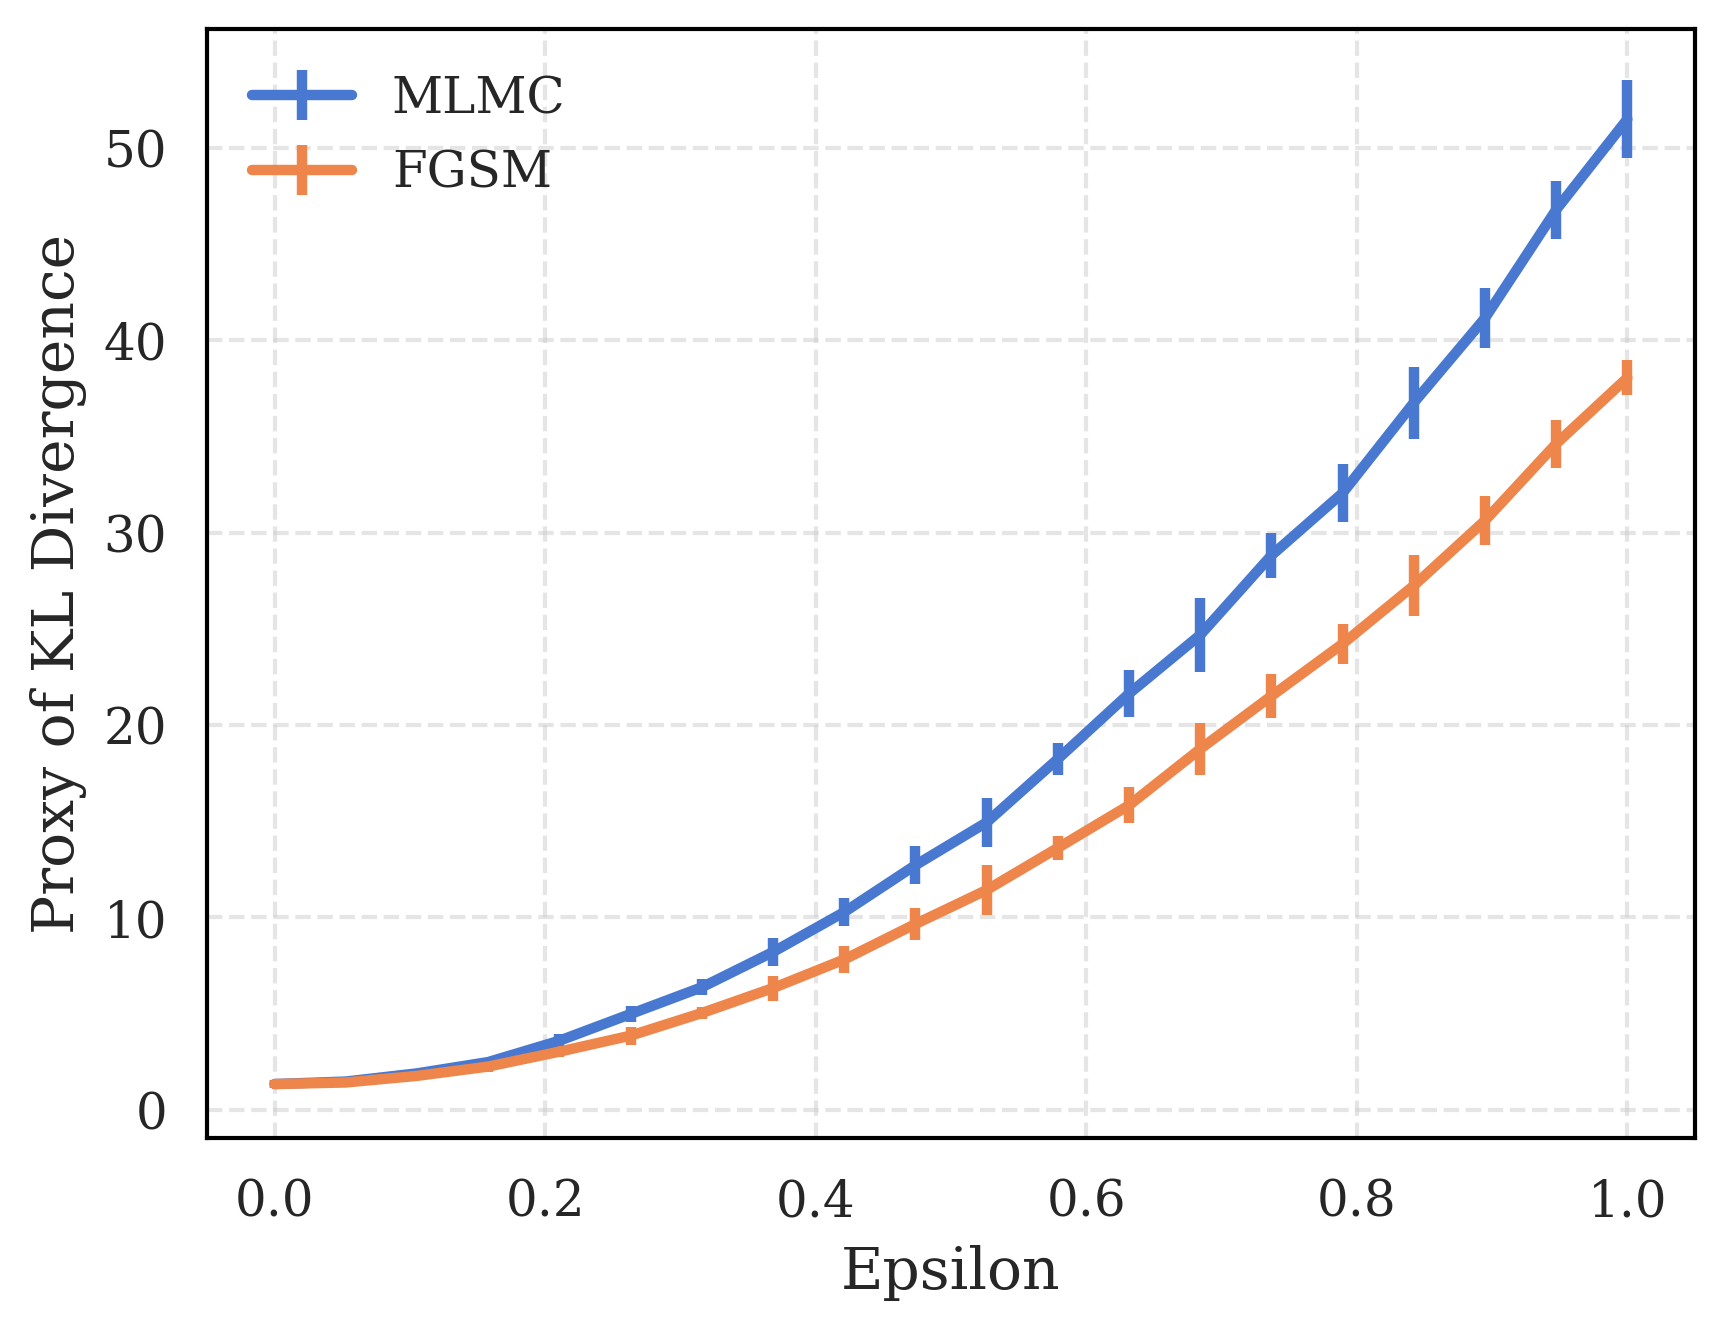

In [25]:
n_jobs = -1

# queremos maximizar E_y[ -\log \pi(y | x', D)] con y \sim p(y | x, D)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=100)
    y_samples = model.sample_predictive_distribution(x, num_samples=100)
    val = -torch.mean(torch.log(pi(y_samples, x_adv_distr, model.sample_posterior_distribution(100))))
    val_fsgm = -torch.mean(torch.log(pi(y_samples, x_fsgm, model.sample_posterior_distribution(100))))
    return val, val_fsgm

kl_alls = []
# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Proxy of KL Divergence')

### Case 2b: Same model as case 1

In [26]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [27]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

(array([193., 136., 165., 137., 100.,  90.,  59.,  48.,  34.,  14.,   9.,
          7.,   4.,   2.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([1.95938349e-02, 2.06692576e+00, 4.11425768e+00, 6.16158960e+00,
        8.20892153e+00, 1.02562535e+01, 1.23035854e+01, 1.43509173e+01,
        1.63982492e+01, 1.84455811e+01, 2.04929131e+01, 2.25402450e+01,
        2.45875769e+01, 2.66349088e+01, 2.86822408e+01, 3.07295727e+01,
        3.27769046e+01, 3.48242365e+01, 3.68715685e+01, 3.89189004e+01,
        4.09662323e+01]),
 <BarContainer object of 20 artists>)

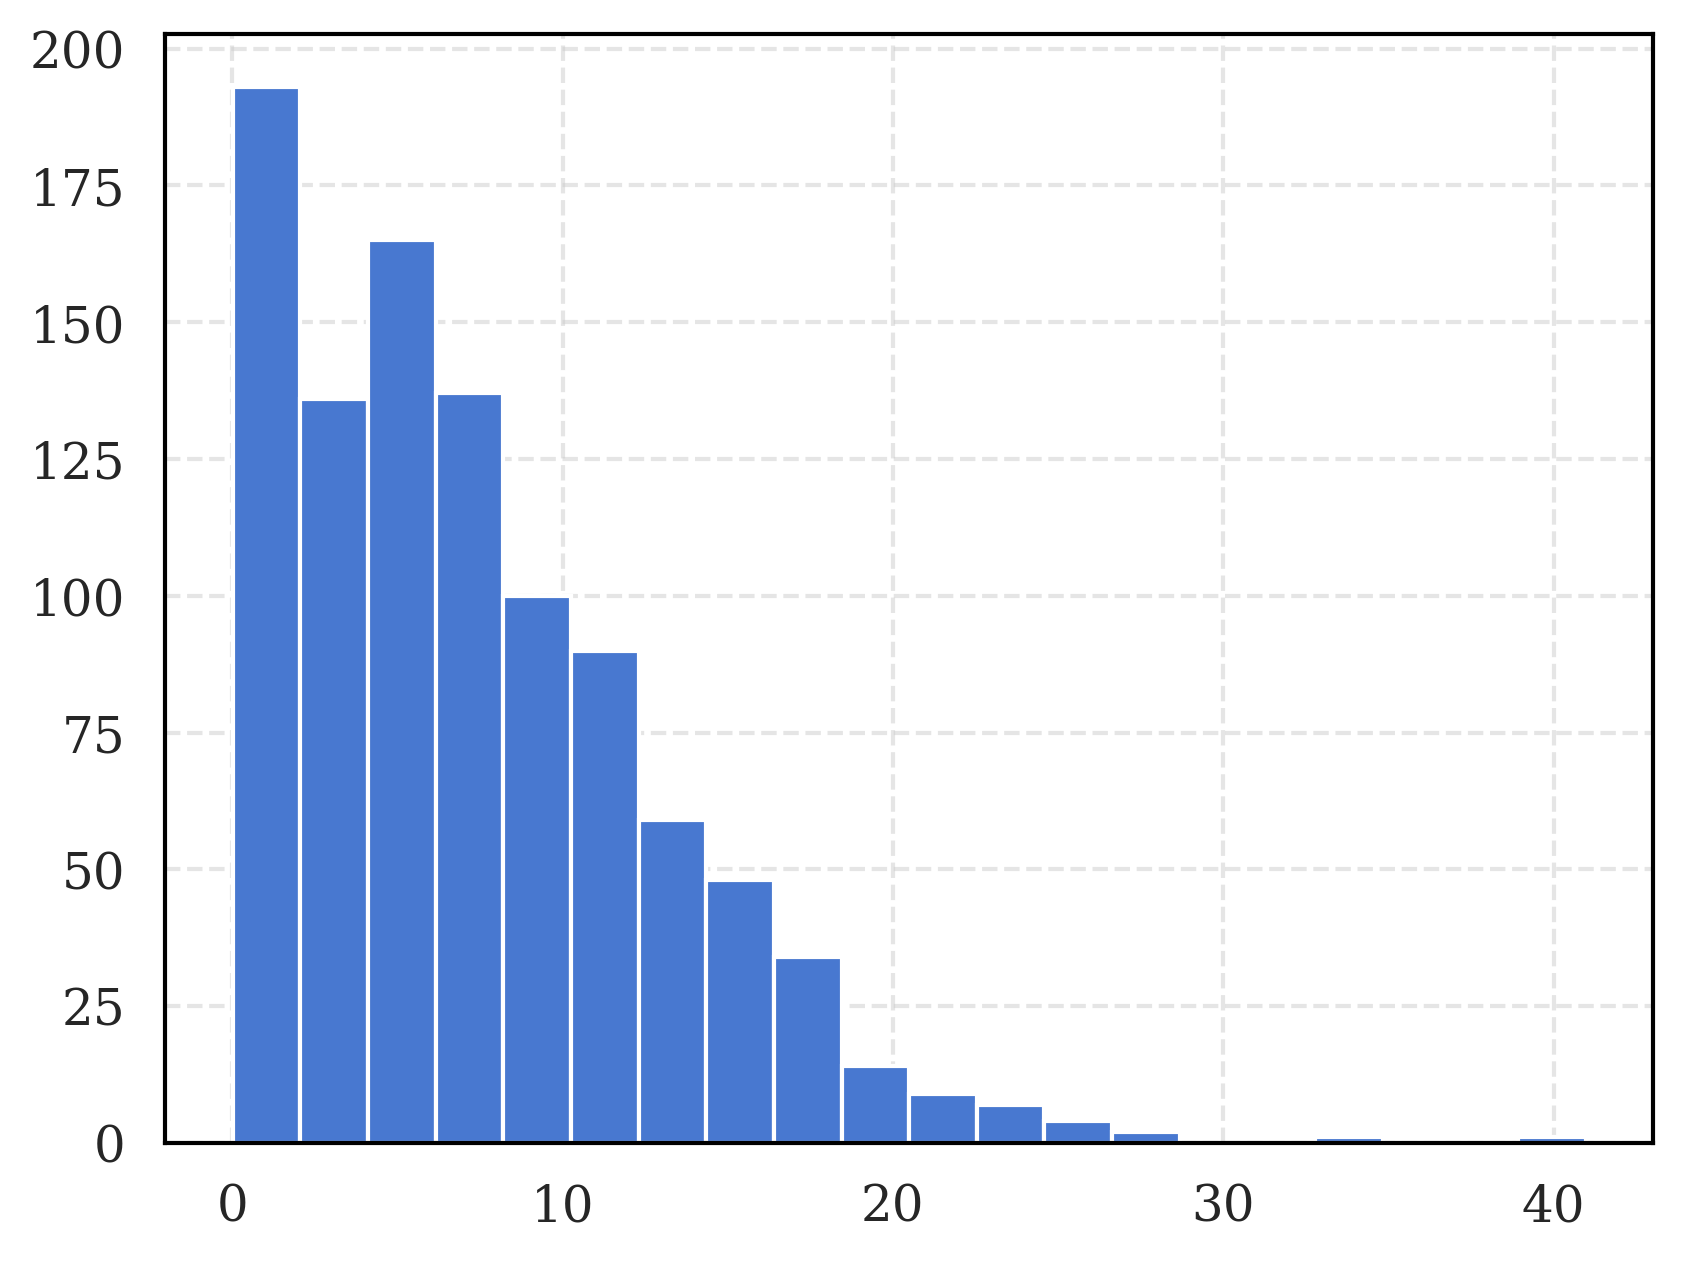

In [28]:
norms = []
for it in range(1000):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    norms.append(torch.norm(real_grad - gradient_estimate).detach().item())
        
plt.hist(norms, bins=20)

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(array([  1.,   1.,   3.,   9.,  10.,  31.,  55.,  89., 131., 138., 151.,
        152., 112.,  44.,  41.,  22.,   7.,   1.,   1.,   1.]),
 array([1.06101525, 1.12902768, 1.19704012, 1.26505255, 1.33306499,
        1.40107742, 1.46908985, 1.53710229, 1.60511472, 1.67312716,
        1.74113959, 1.80915202, 1.87716446, 1.94517689, 2.01318933,
        2.08120176, 2.1492142 , 2.21722663, 2.28523906, 2.3532515 ,
        2.42126393]),
 <BarContainer object of 20 artists>)

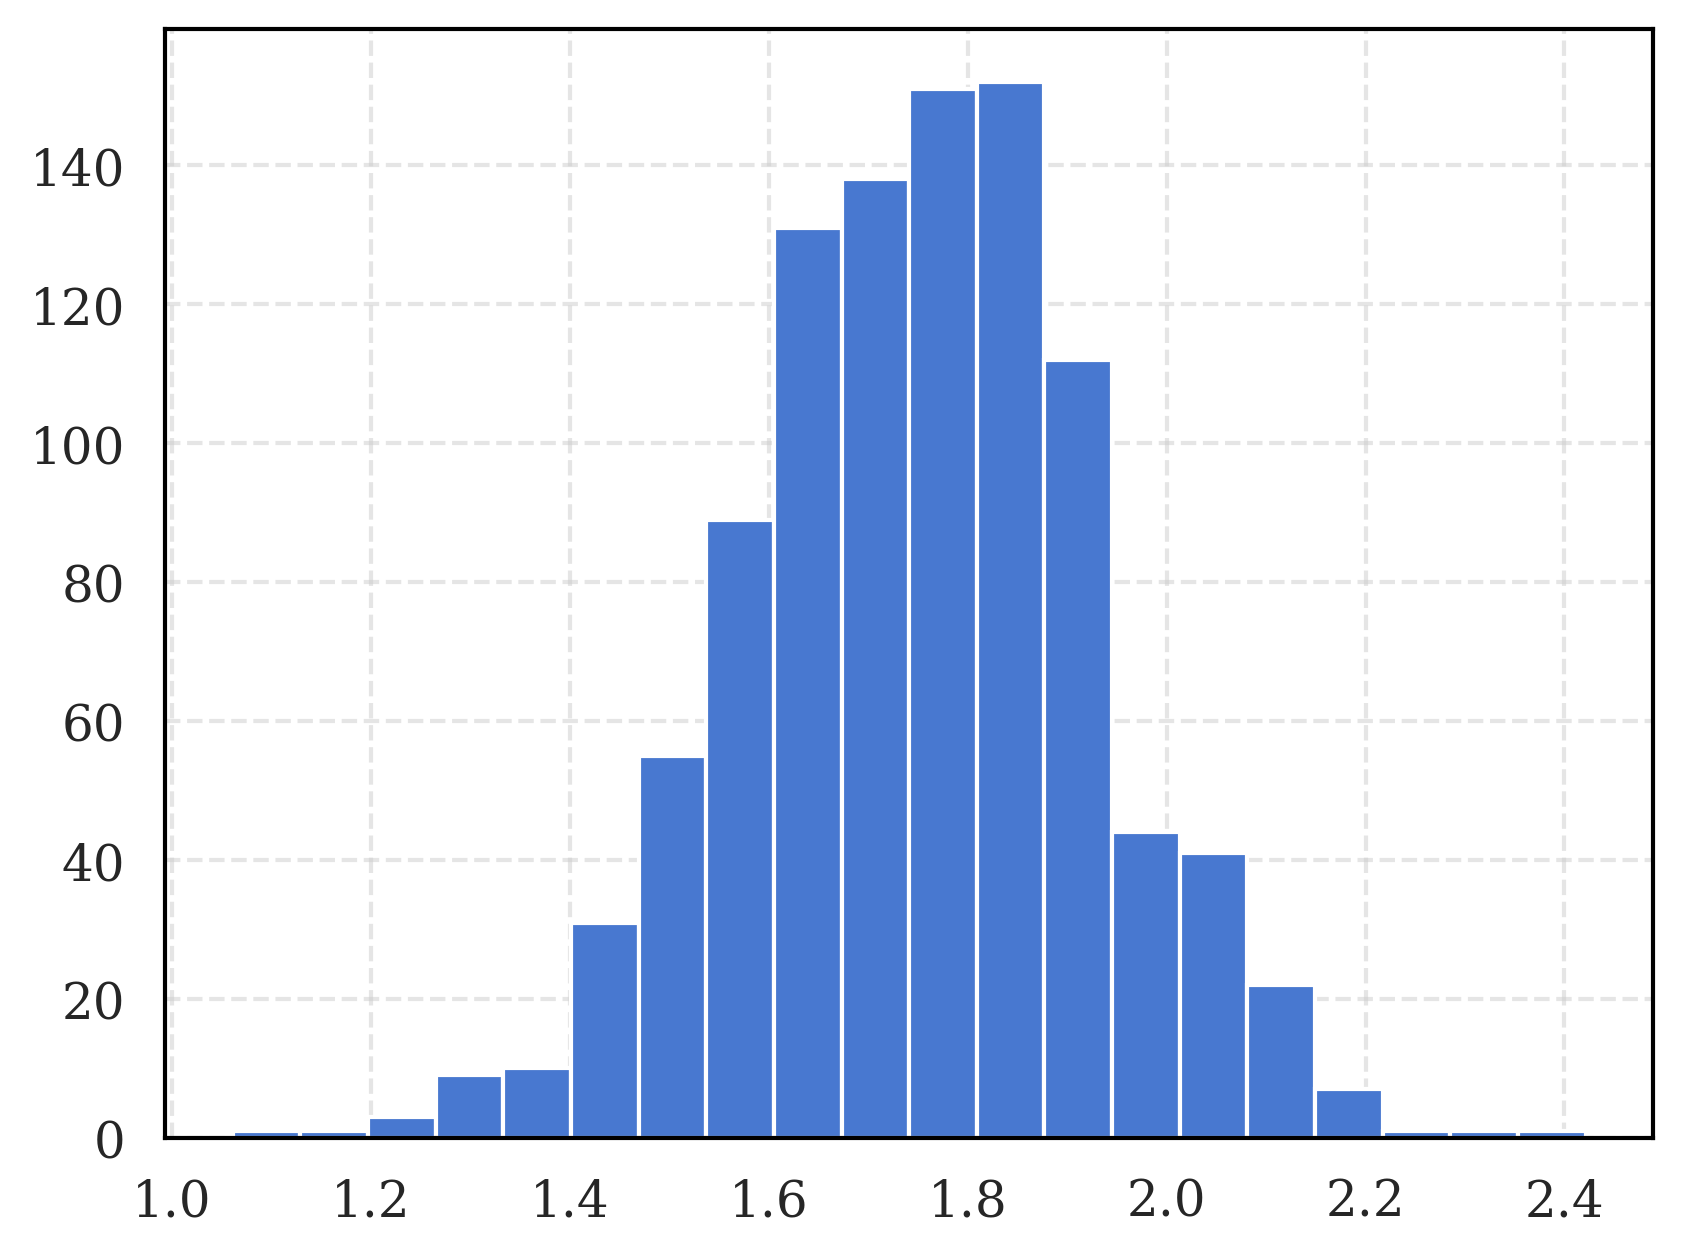

In [29]:
# same as before but estimate the gradient doing the mean of 1000 iterations and doing it in paralell with joblib

def compute_norms(it):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
    for _ in range(100):
        y = model.sample_predictive_distribution(x, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
        gradient_estimate += gradient_estimate
    gradient_estimate /= 101
    return torch.norm(real_grad - gradient_estimate).detach().item()

n_jobs = 66
norms = Parallel(n_jobs=n_jobs)(delayed(compute_norms)(i) for i in range(1000))
plt.hist(norms, bins=20)

Long gradient estimation time: 5.57306170463562 for iteration 0


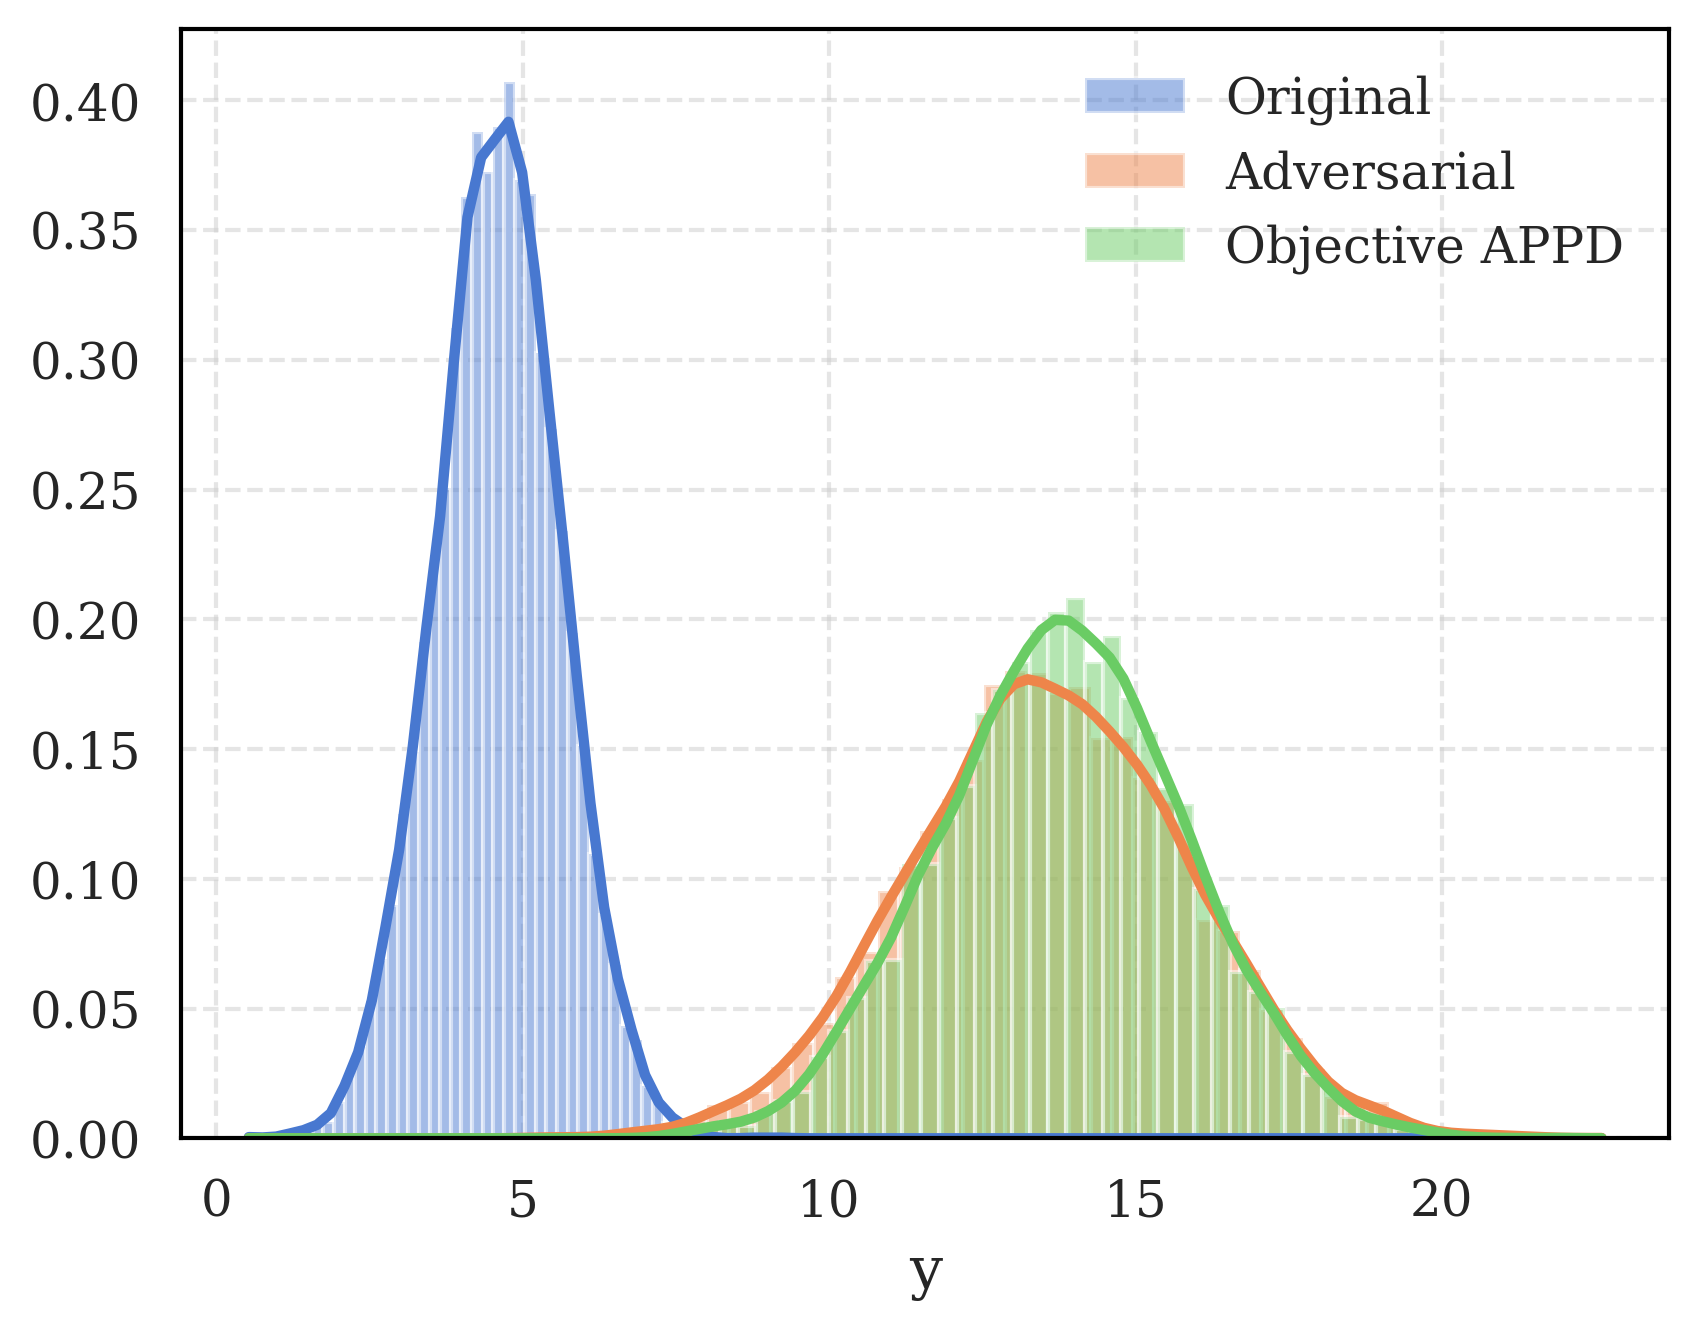

In [30]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(3 * x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5)
plot_ppds(model, x, x_adv_distr, appd)

Early stopping at iteration 426


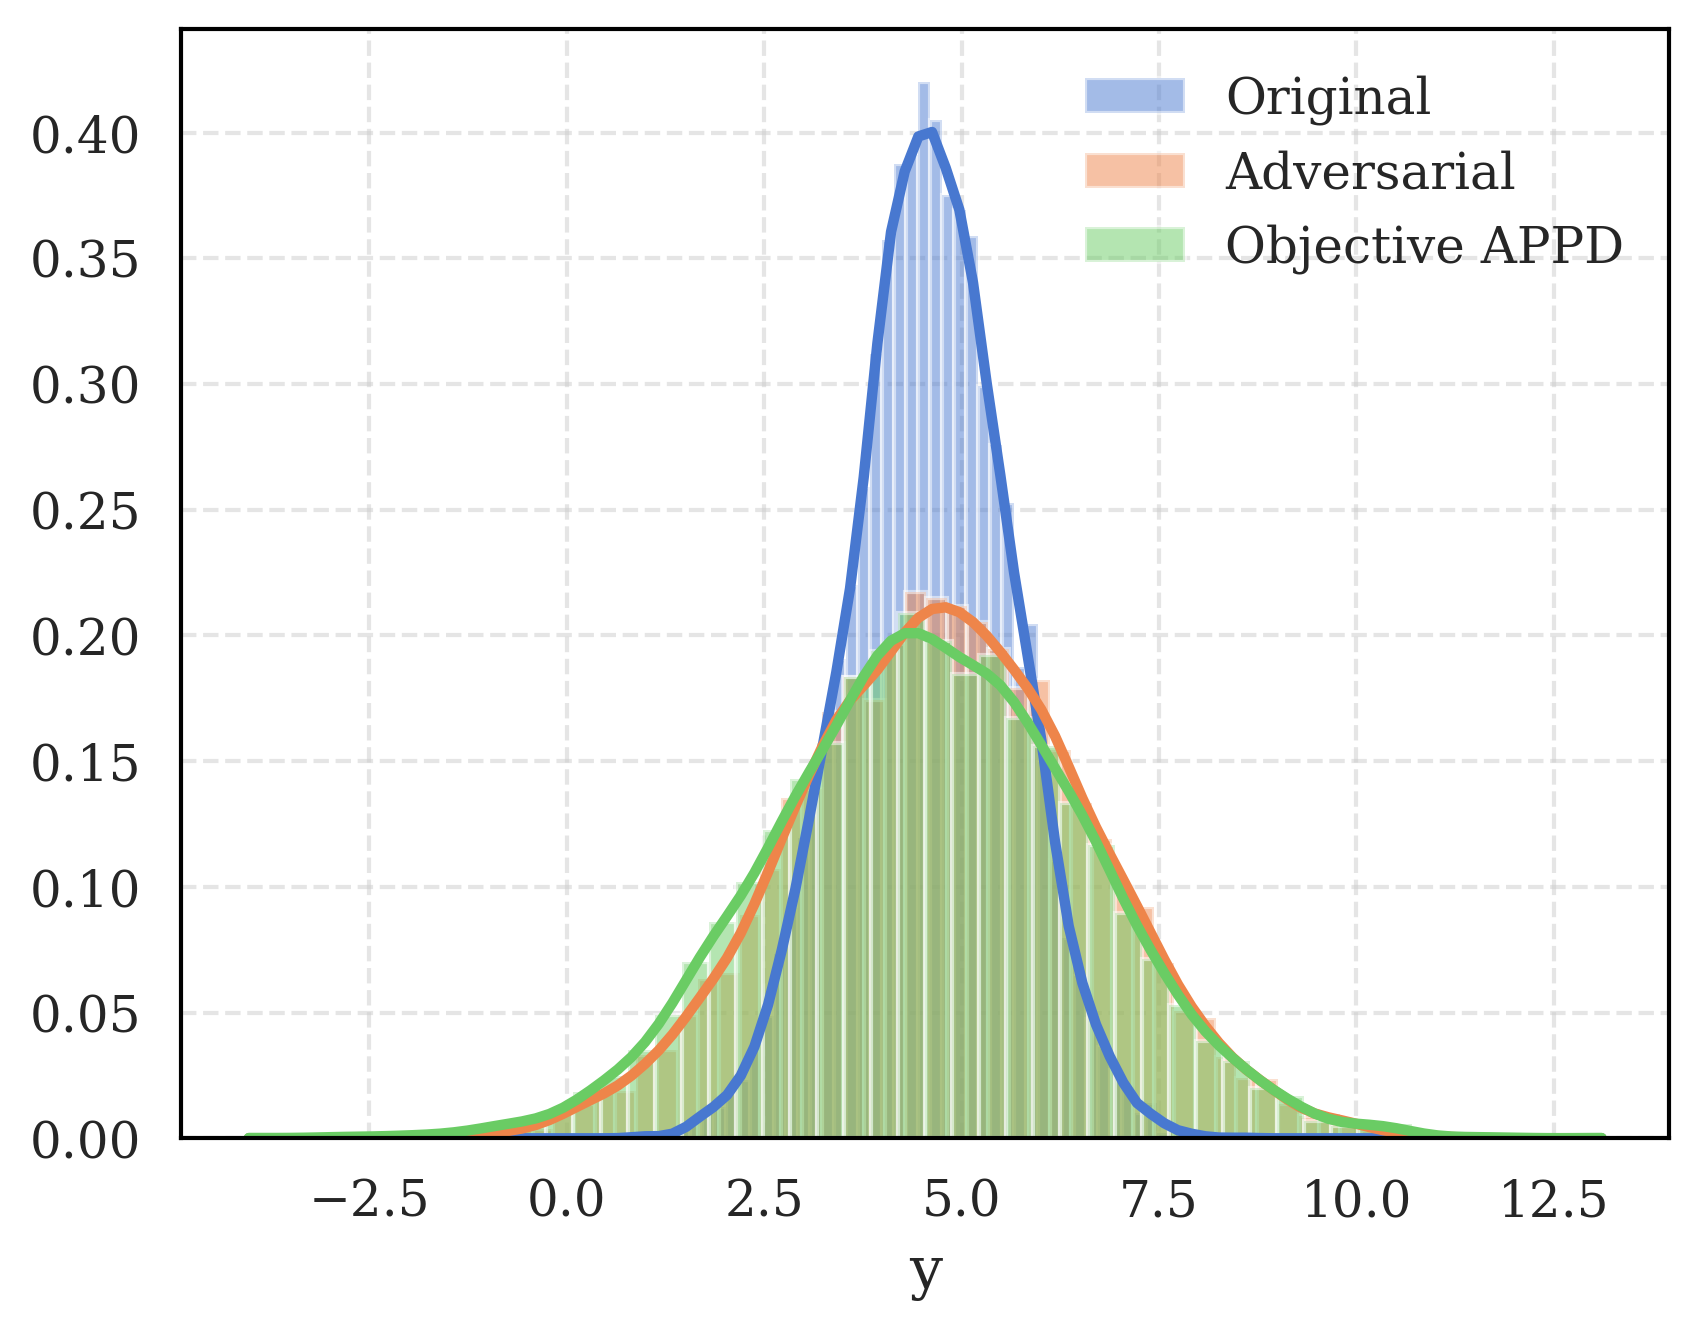

In [31]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2)
plot_ppds(model, x, x_adv_distr, appd)

Early stopping at iteration 15


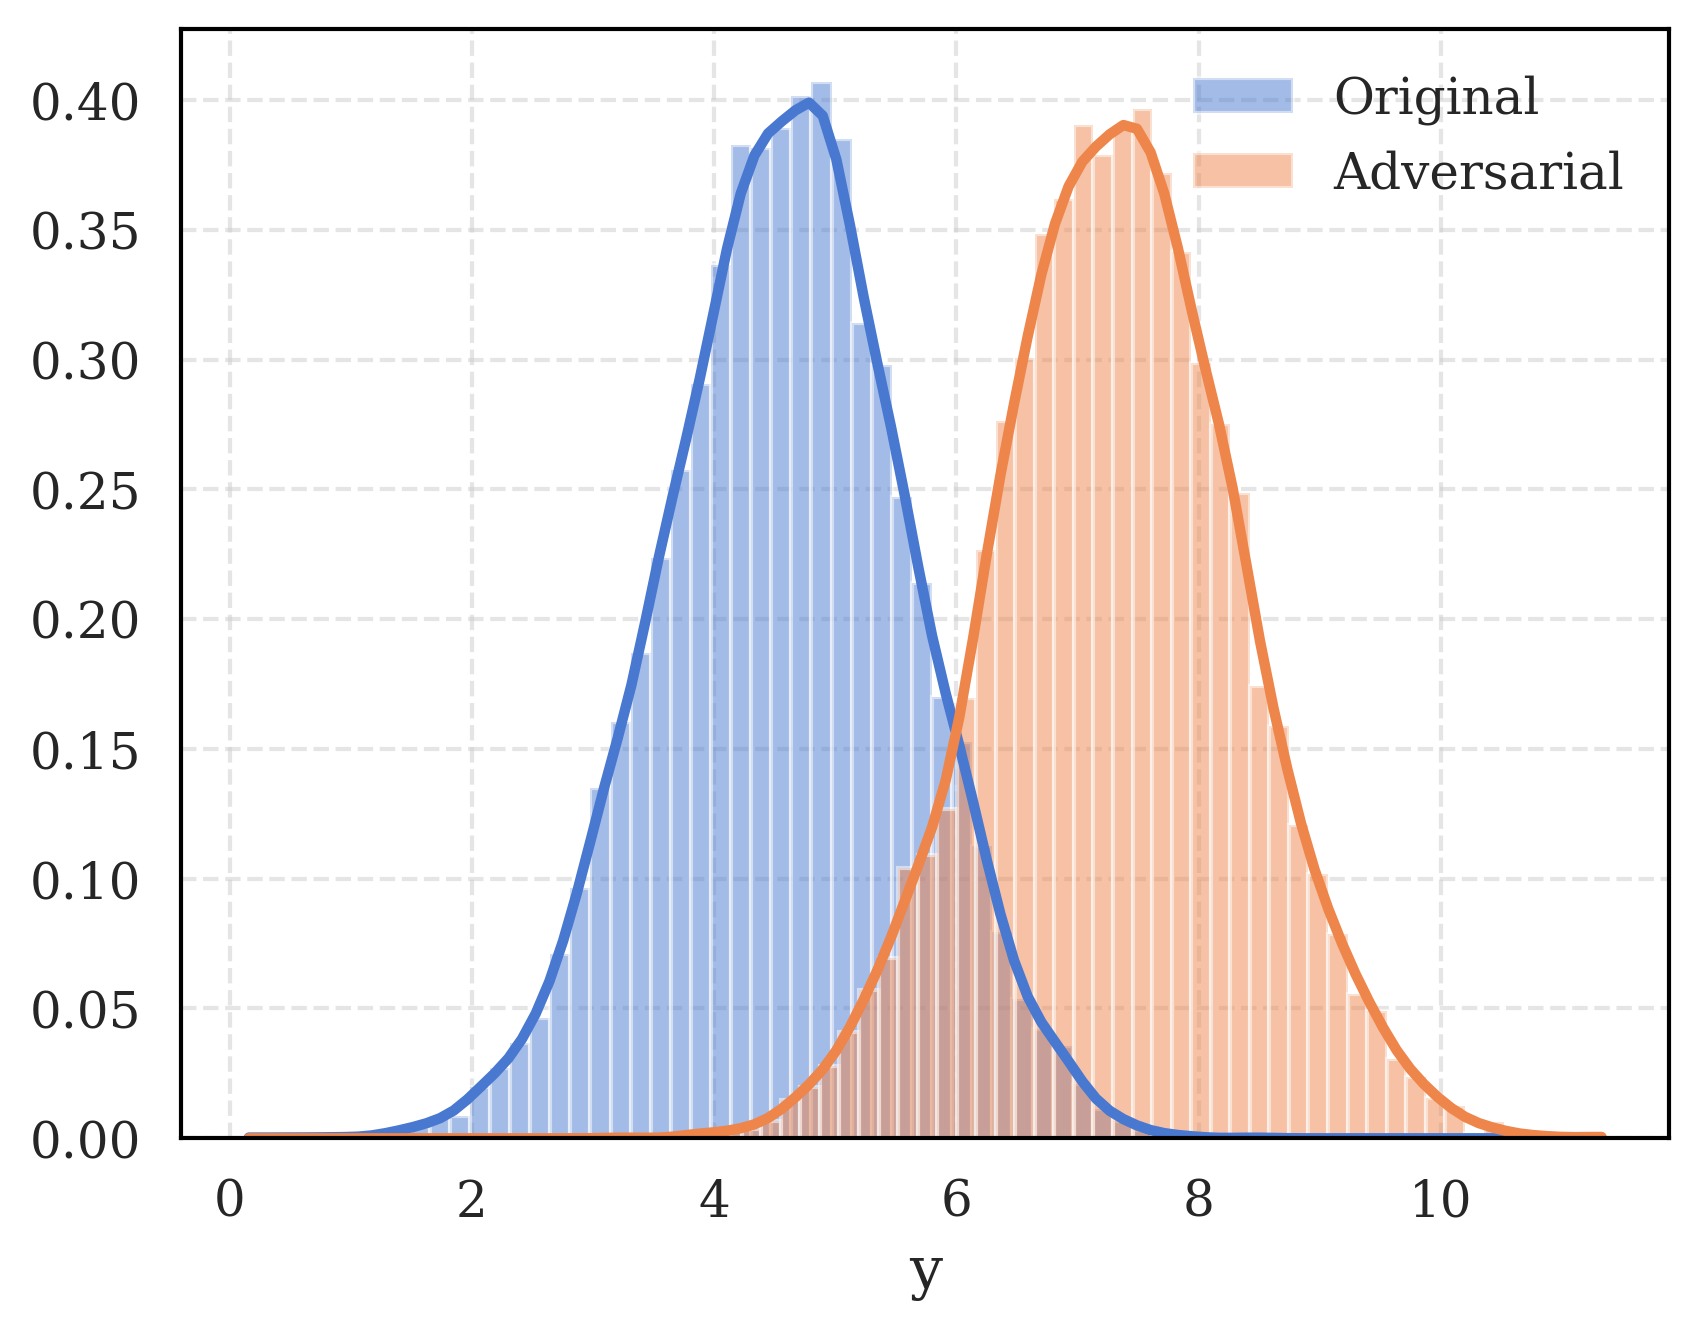

In [32]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=0.3)
plot_ppds(model, x, x_adv_distr)

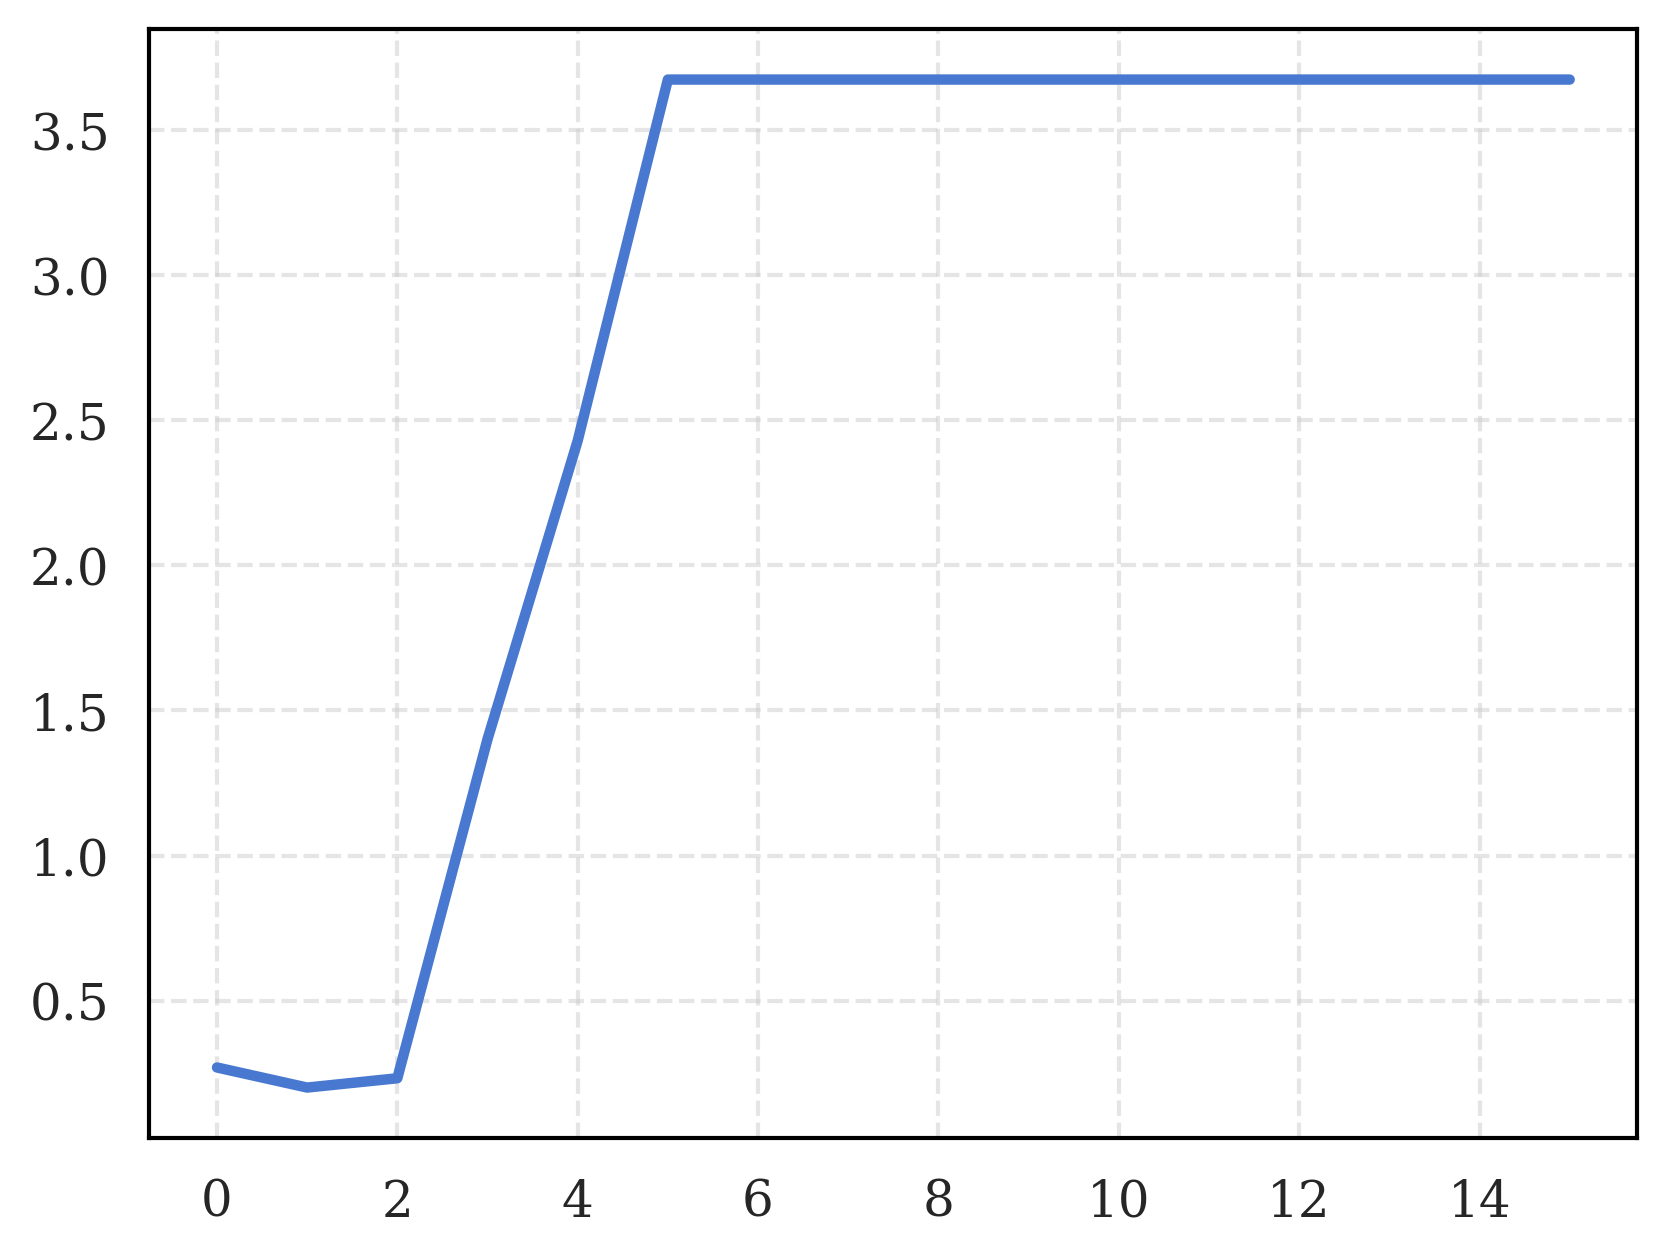

In [33]:
# plot KL evolution
kl_values = [kl_div(model.mu, model.lam, model.sigma2, x, torch.tensor(x_adv, dtype=torch.float32)).item() for x_adv in x_adv_values]

plt.plot(kl_values)

Early stopping at iteration 102
Early stopping at iteration 102
Early stopping at iteration 107
Early stopping at iteration 146


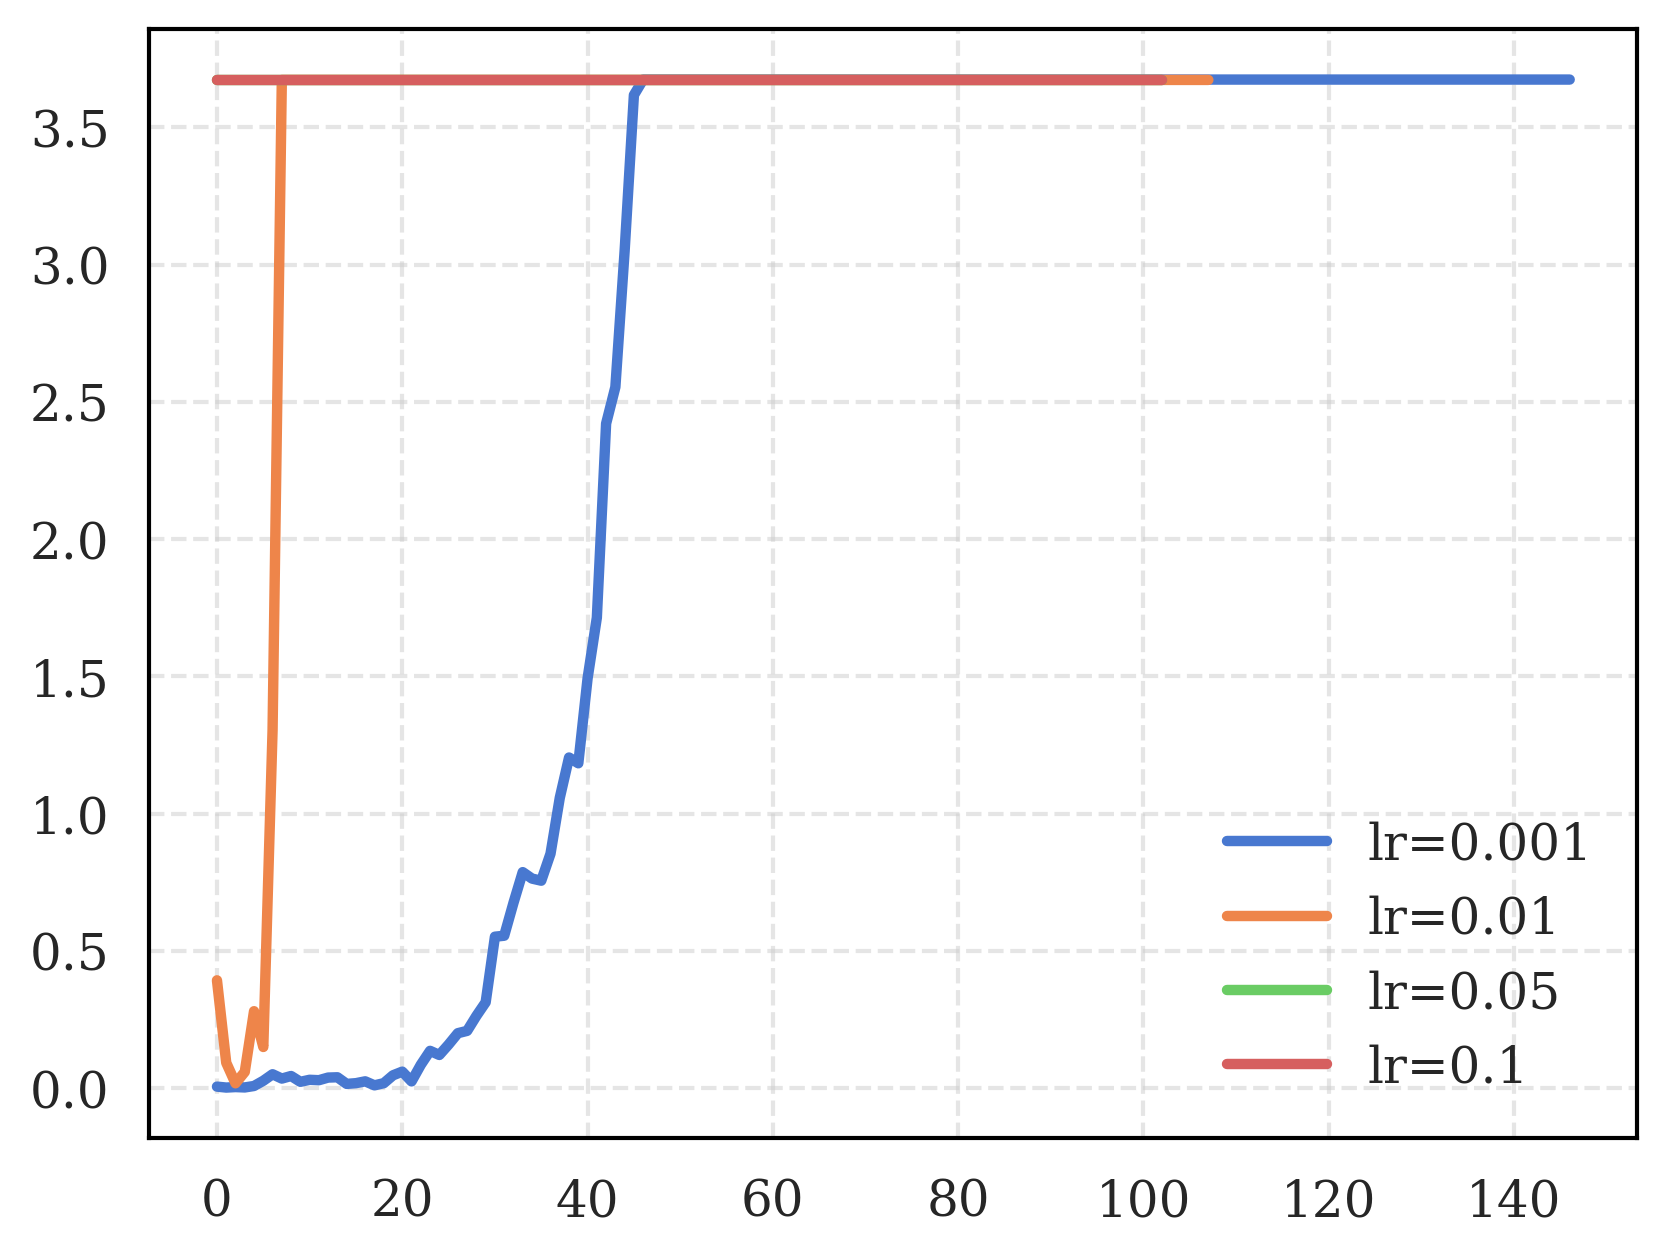

In [34]:
# plot kl evolution for different learning rates with joblib
lrs = [0.001, 0.01, 0.05, 0.1]

n_jobs = -1

def kl_values(lr):
    x = X_test[17,:].copy()
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    x_adv_distr, x_adv_values = mlmc_attack(model, x, lr=lr, epsilon=0.3, early_stopping_patience=100)
    kl_values = [kl_div(model.mu, model.lam, model.sigma2, x, torch.tensor(x_adv, dtype=torch.float32)).item() for x_adv in x_adv_values]
    return kl_values    

kl_values_list = Parallel(n_jobs=n_jobs)(
    delayed(kl_values)(lr) for lr in lrs
)

for kls, lr in zip(kl_values_list, lrs):
    plt.plot(kls, label=f'lr={lr}')
plt.legend()

Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 16
Early stopping at iteration 17
Early stopping at iteration 17
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14Early stopping at iteration 14

Early st

Text(0, 0.5, 'KL Divergence')

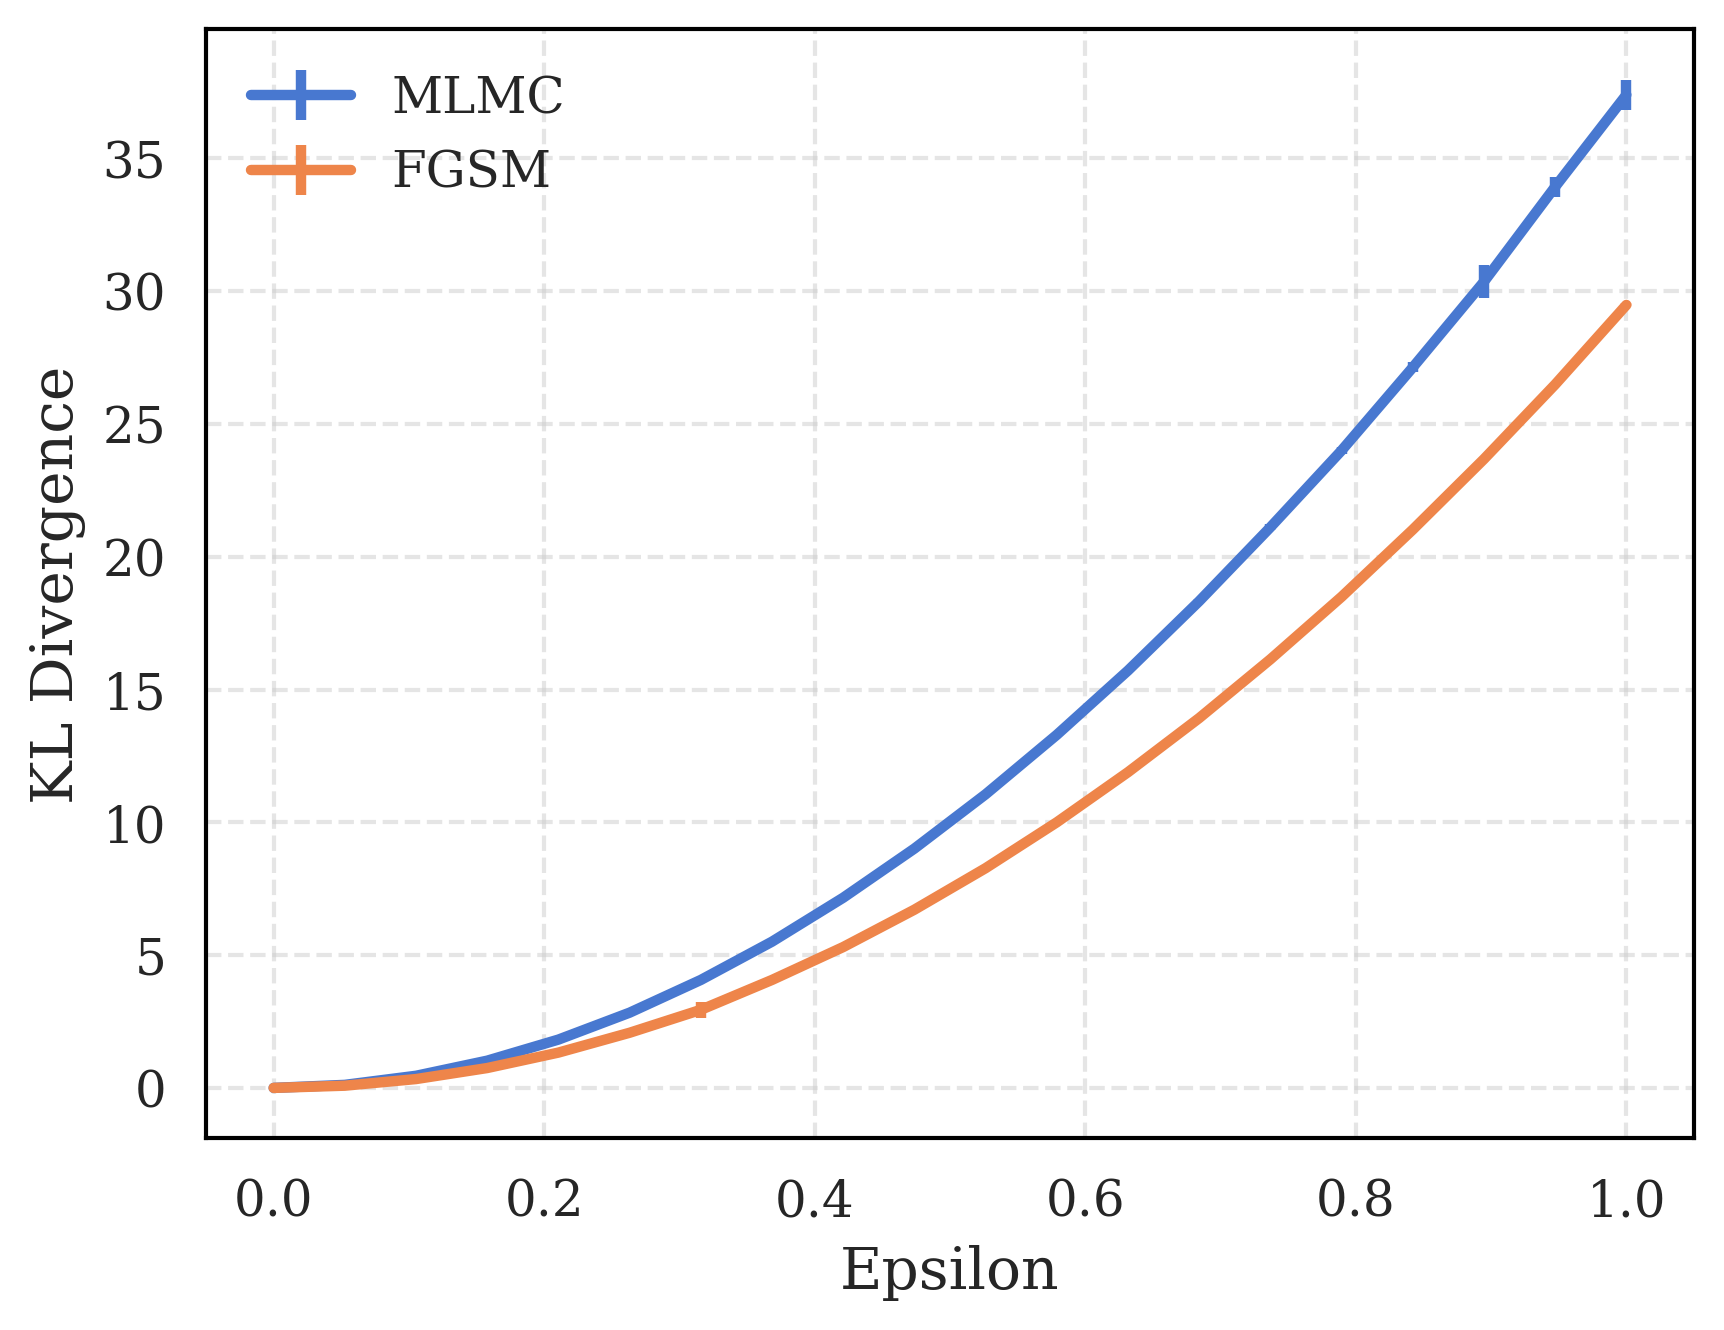

In [35]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=100)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('KL Divergence')

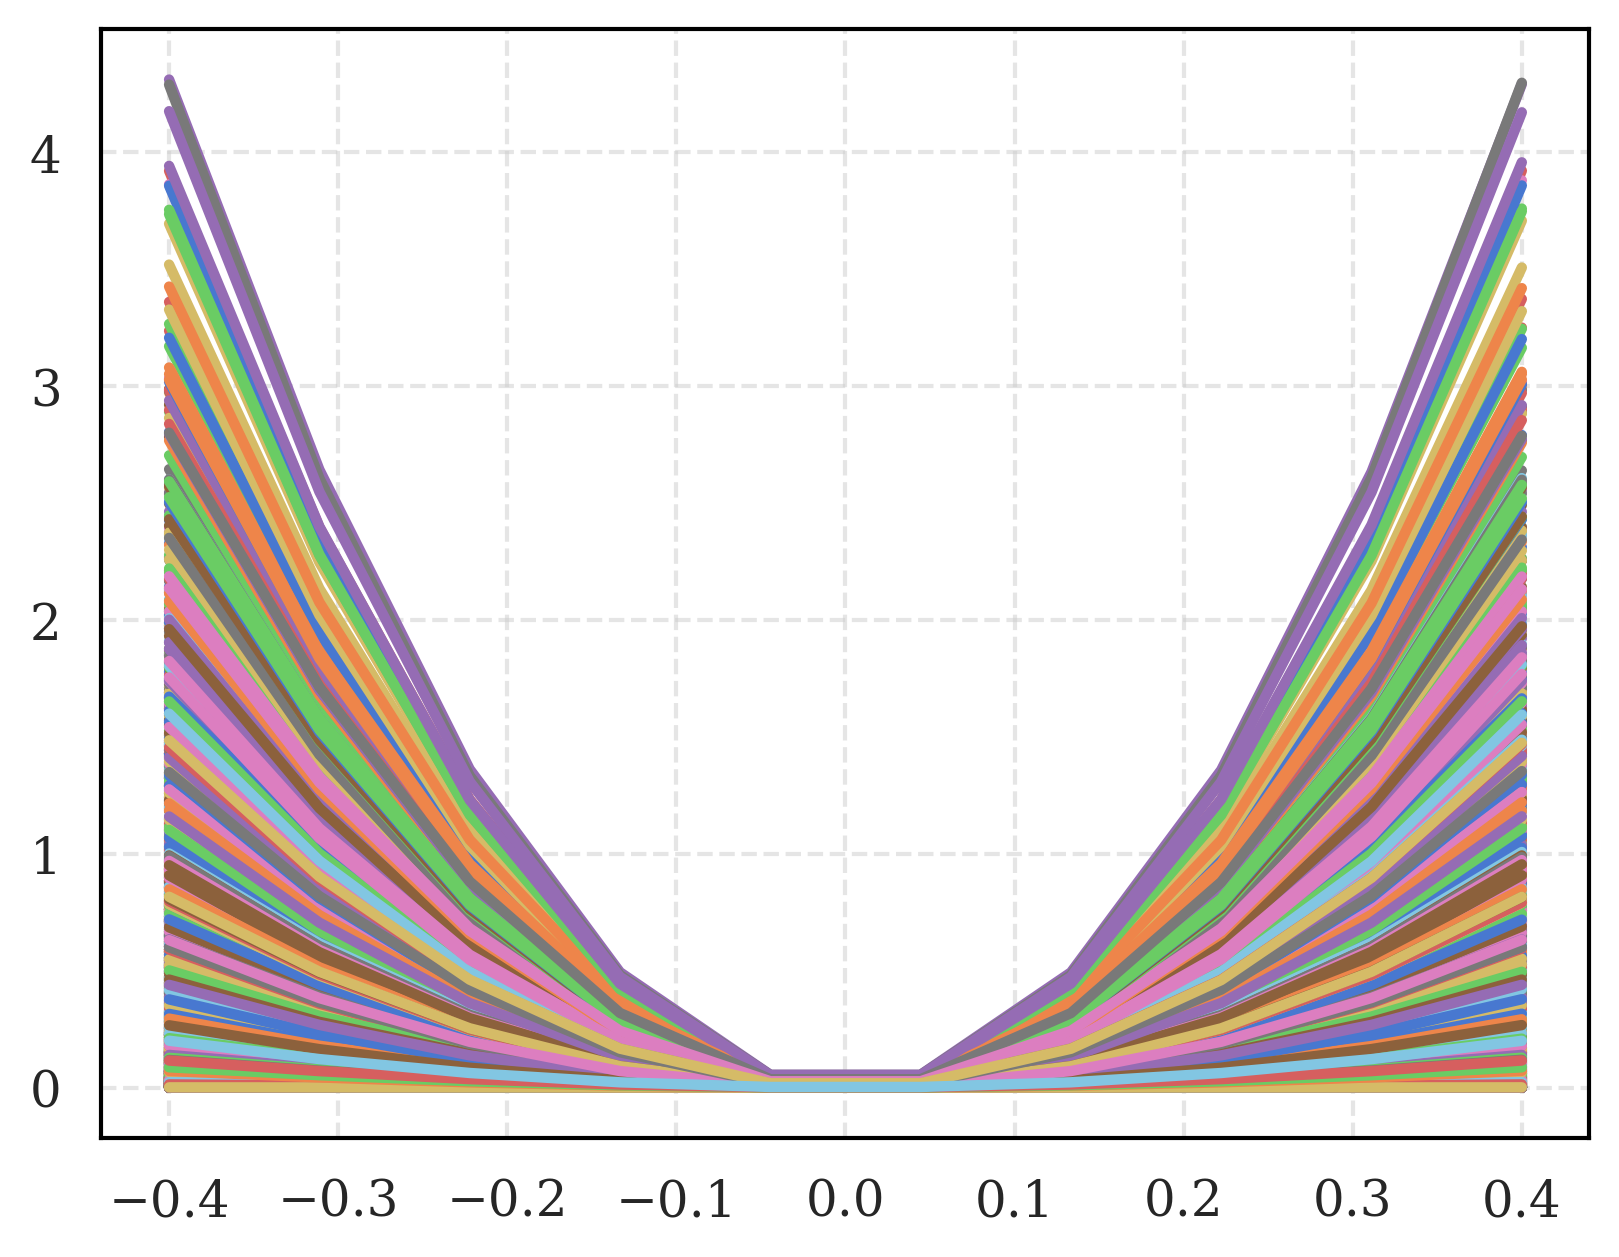

In [36]:
# For random directions (no attack), plot the KL divergence as a function of the strength of the attack
n_directions = 2000
n_values_per_direction = 10
kl_lists = []
eps_max = .4

for _ in range(n_directions):
    direction = torch.randn_like(x)
    direction /= torch.norm(direction, p=2)
    kl_values = []
    for epsilon in np.linspace(-1 * eps_max, 1 * eps_max, n_values_per_direction):
        x_adv = x + epsilon * direction
        kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv).item()
        kl_values.append(kl)
    kl_lists.append(kl_values)

# represent each line in a different color
for kl_values in kl_lists:
    plt.plot(np.linspace(-1 * eps_max, 1 * eps_max, n_values_per_direction), kl_values)


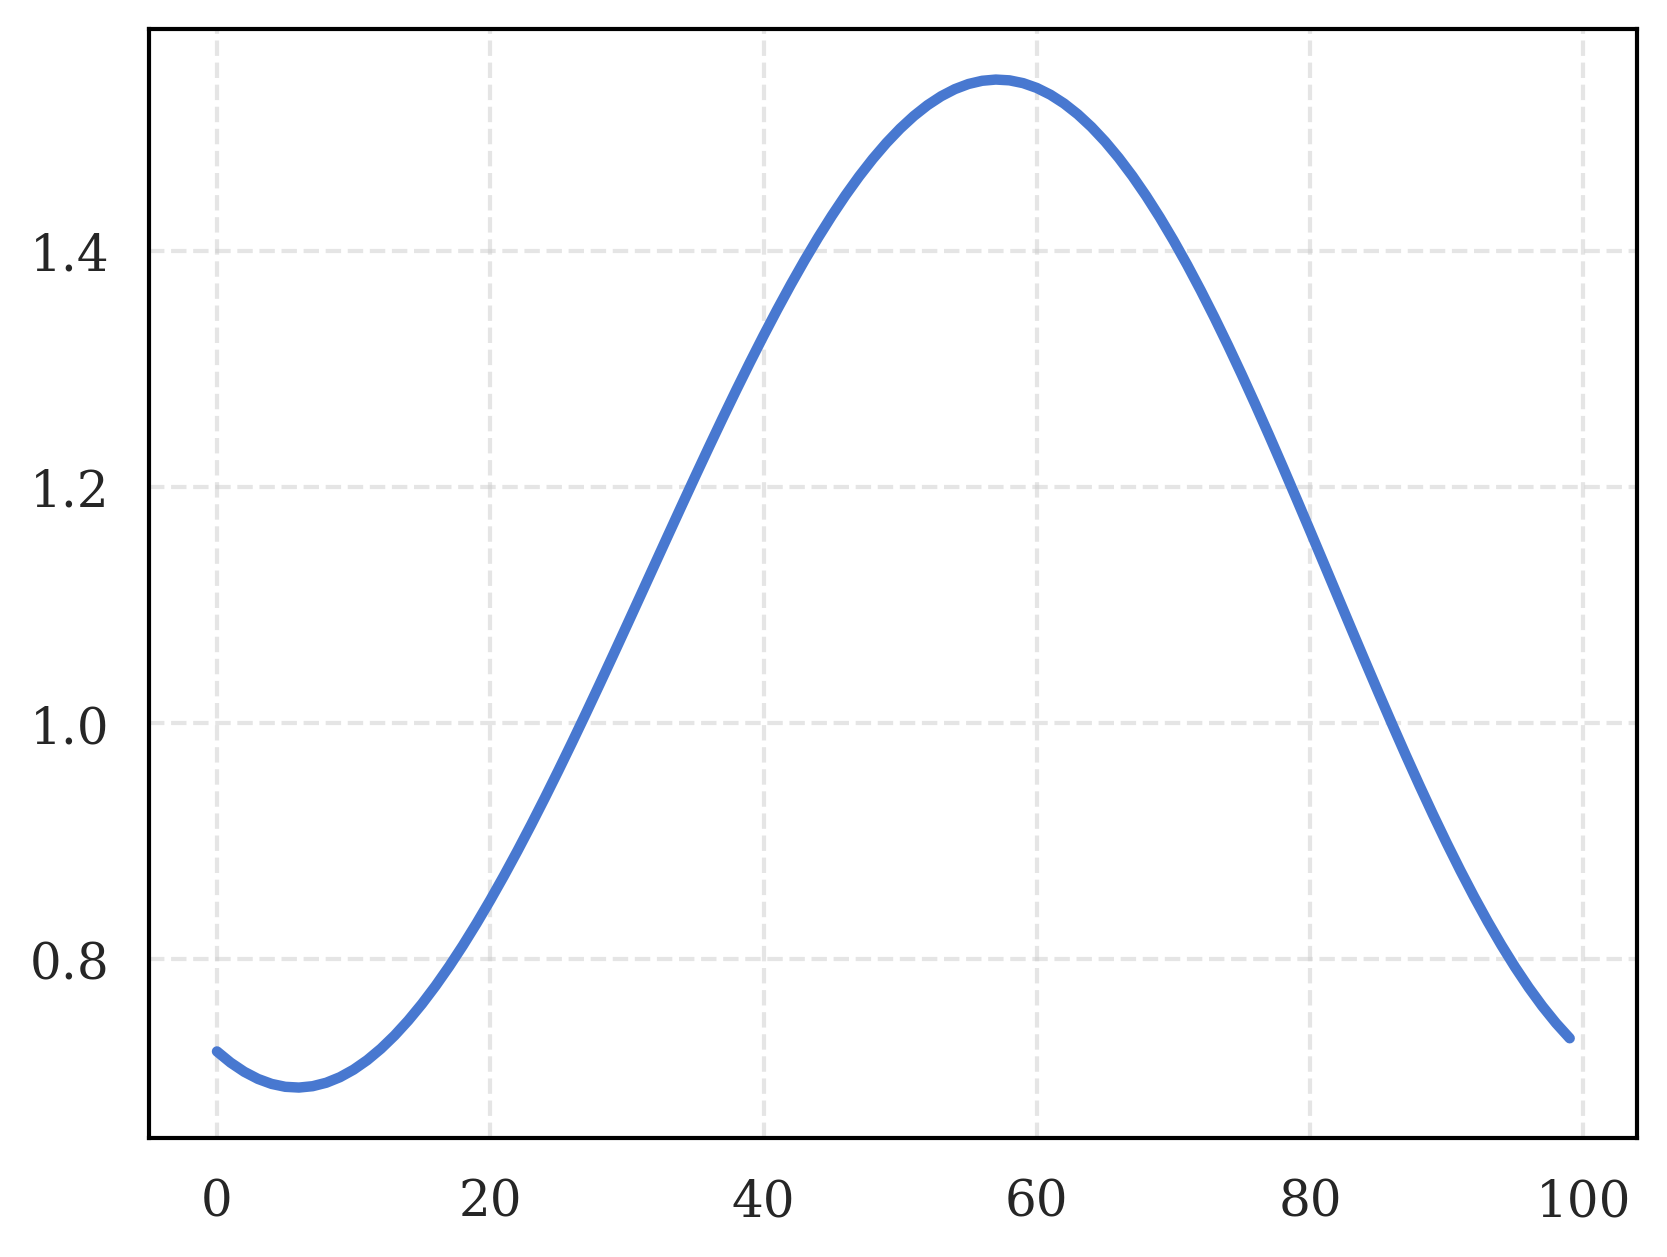

In [37]:
kl_values = []
num_ite = 100

original_point = torch.randn_like(x)
original_point /= torch.norm(original_point, p=2)
original_point = x + eps_max * original_point

direction = torch.randn_like(x)
direction /= torch.norm(direction, p=2)

ortogonal_direction = torch.randn_like(x)
ortogonal_direction /= torch.norm(ortogonal_direction, p=2)
ortogonal_direction = ortogonal_direction - ortogonal_direction.T @ direction * direction
ortogonal_direction /= torch.norm(ortogonal_direction, p=2)

for it in range(num_ite):
    border_point = original_point + direction * np.cos(2 * it * np.pi / num_ite) + ortogonal_direction * np.sin(2 * it * np.pi / num_ite)
    border_point /= torch.norm(border_point, p=2)
    border_point = x + eps_max * border_point

    kl = kl_div(model.mu, model.lam, model.sigma2, x, border_point).item()
    kl_values.append(kl)

plt.plot(kl_values)

## Toy dataset

In [38]:
# Set seeds for reproducibility 
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [39]:
X, y = get_toy_data()

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Model for which we know the true gradient
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

Long gradient estimation time: 6.051638603210449 for iteration 0


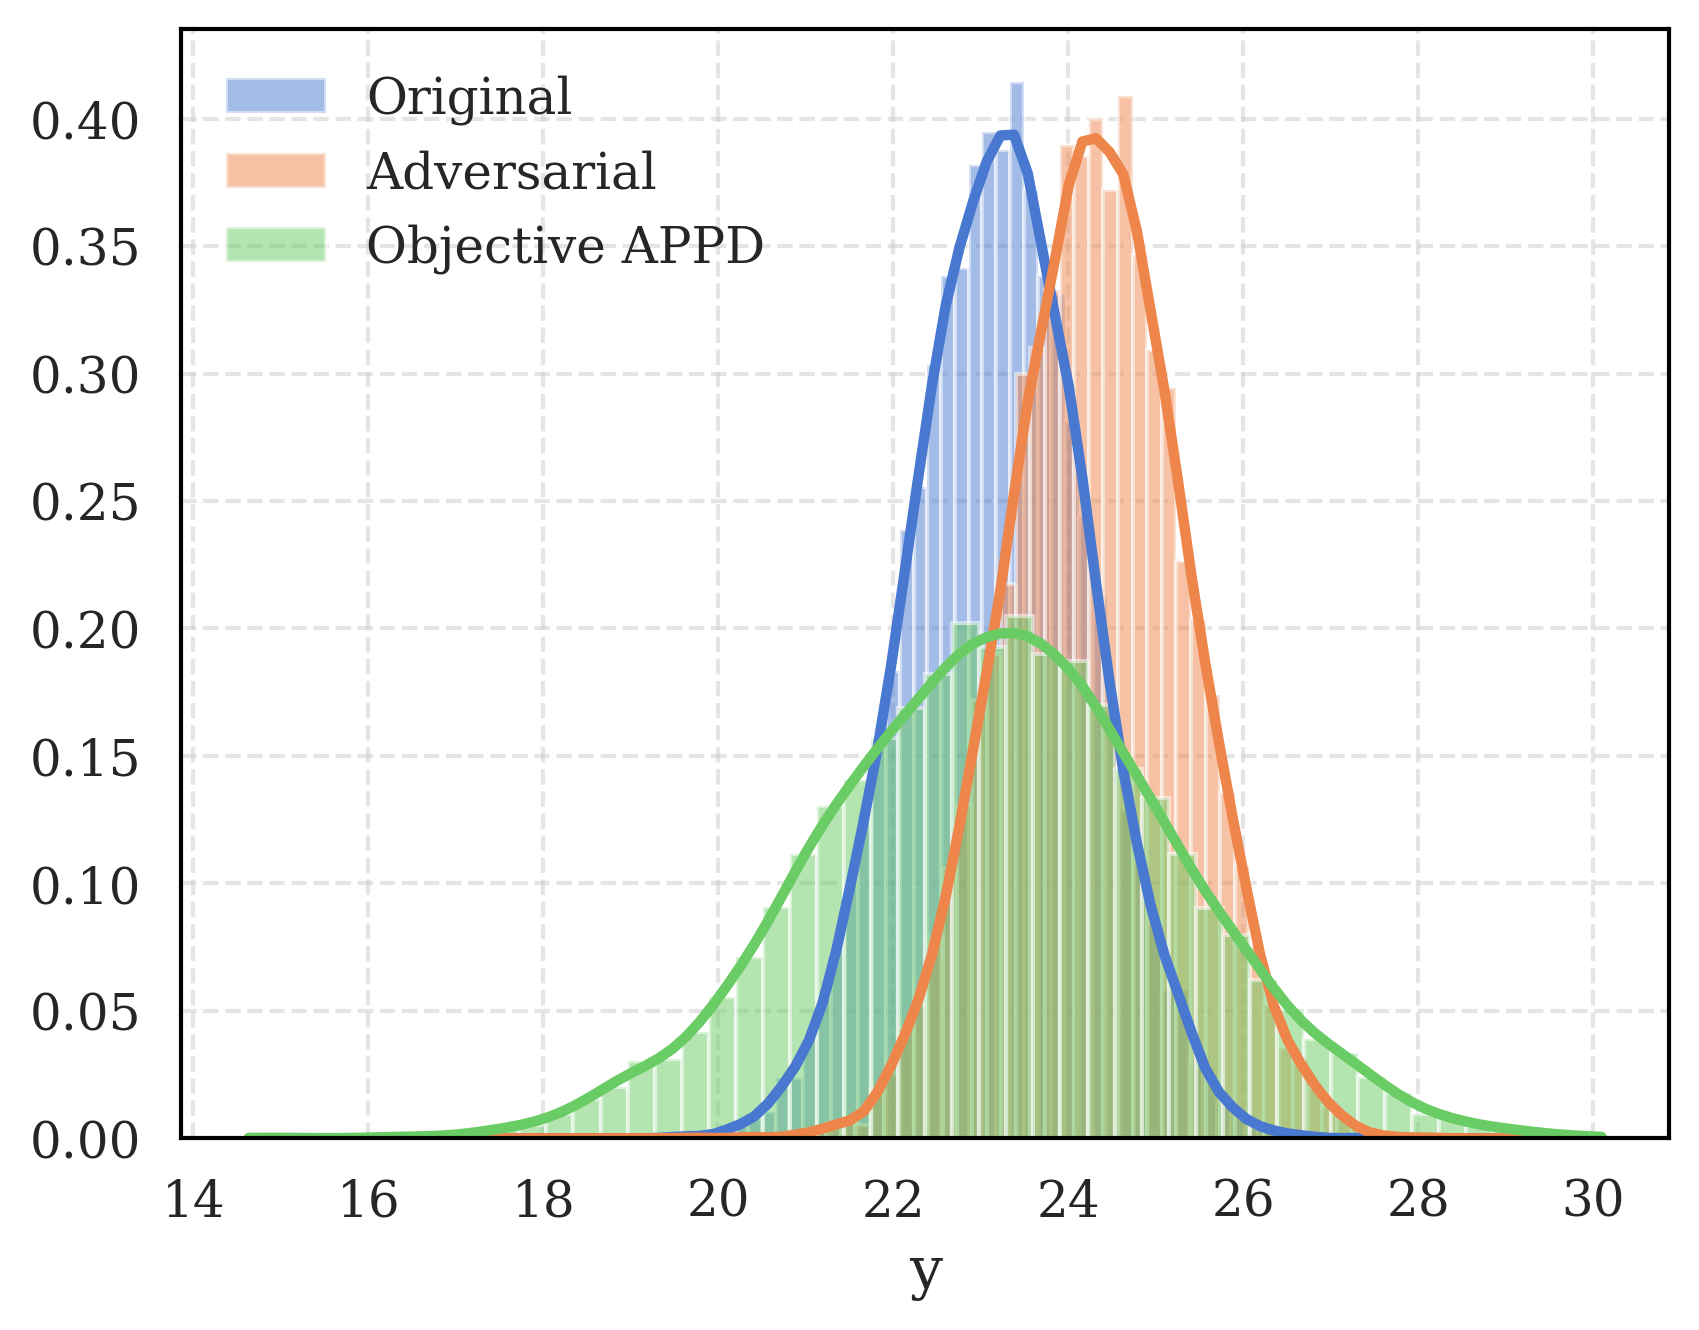

In [40]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=100, lr=0.001, n_iter=2000)
plot_ppds(model, x, x_adv_distr, appd)

In [41]:
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = x.clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

In [42]:
grads = []
for it in range(10000):
    y = model.sample_predictive_distribution(x, num_samples=1)
    grads.append(mlmc_gradient_estimator(y, x_adv, 100, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 22
Early stopping at iteration 16
Early stopping at iteration 15
Early stopping at iteration 17
Early stopping at iteration 15
Early stopping at iteration 13
Early stopping at iteration 19
Early stopping at iteration 25
Early stopping at iteration 17
Early stopping at iteration 18
Early stopping at iteration 16
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 20
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 16
Early stopping at iteration 18
Early stopping at iteration 13
Early stopping at iteration 14
Early st

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Early stopping at iteration 16
Early stopping at iteration 16
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 16
Early stopping at iteration 13
Early stopping at iteration 15
Early stopping at iteration 15
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 17
Early stopping at iteration 13
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 16
Early stopping at iteration 13
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 18
Early stopping at iteration 15
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 14
Early st

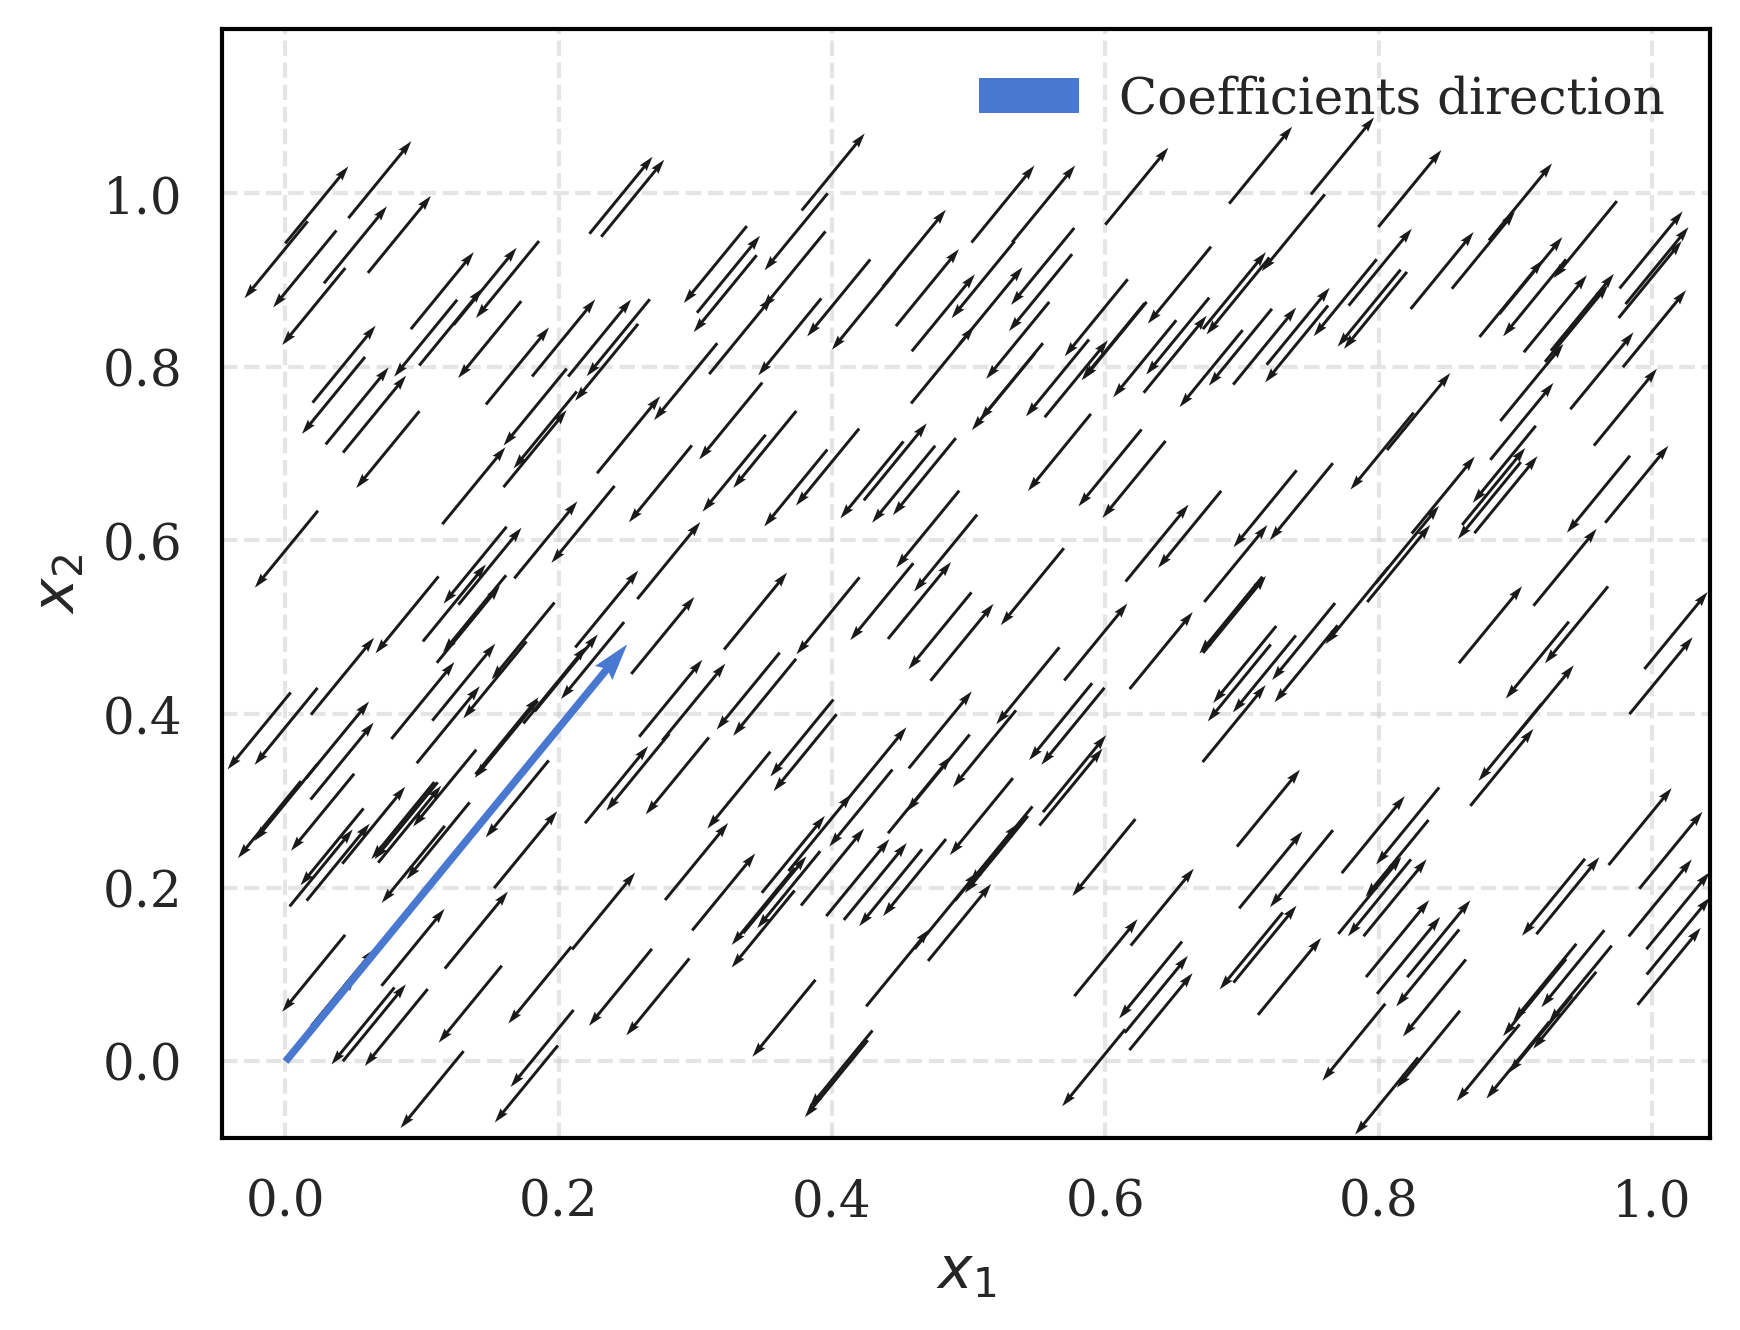

In [42]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    x_adv, x_adv_values = mlmc_attack(model, x, lr=0.001)
    perturbations.append(x.clone().detach().numpy() - x_adv.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 19
Early stopping at iteration 13
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 18
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 18
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 24
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 16
Early stopping at iteration 15
Early stopping at iteration 17
Early stopping at iteration 18
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 18
Early stopping at iteration 21
Early stopping at iteration 16
Early stopping at iteration 17
Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 21
Early st

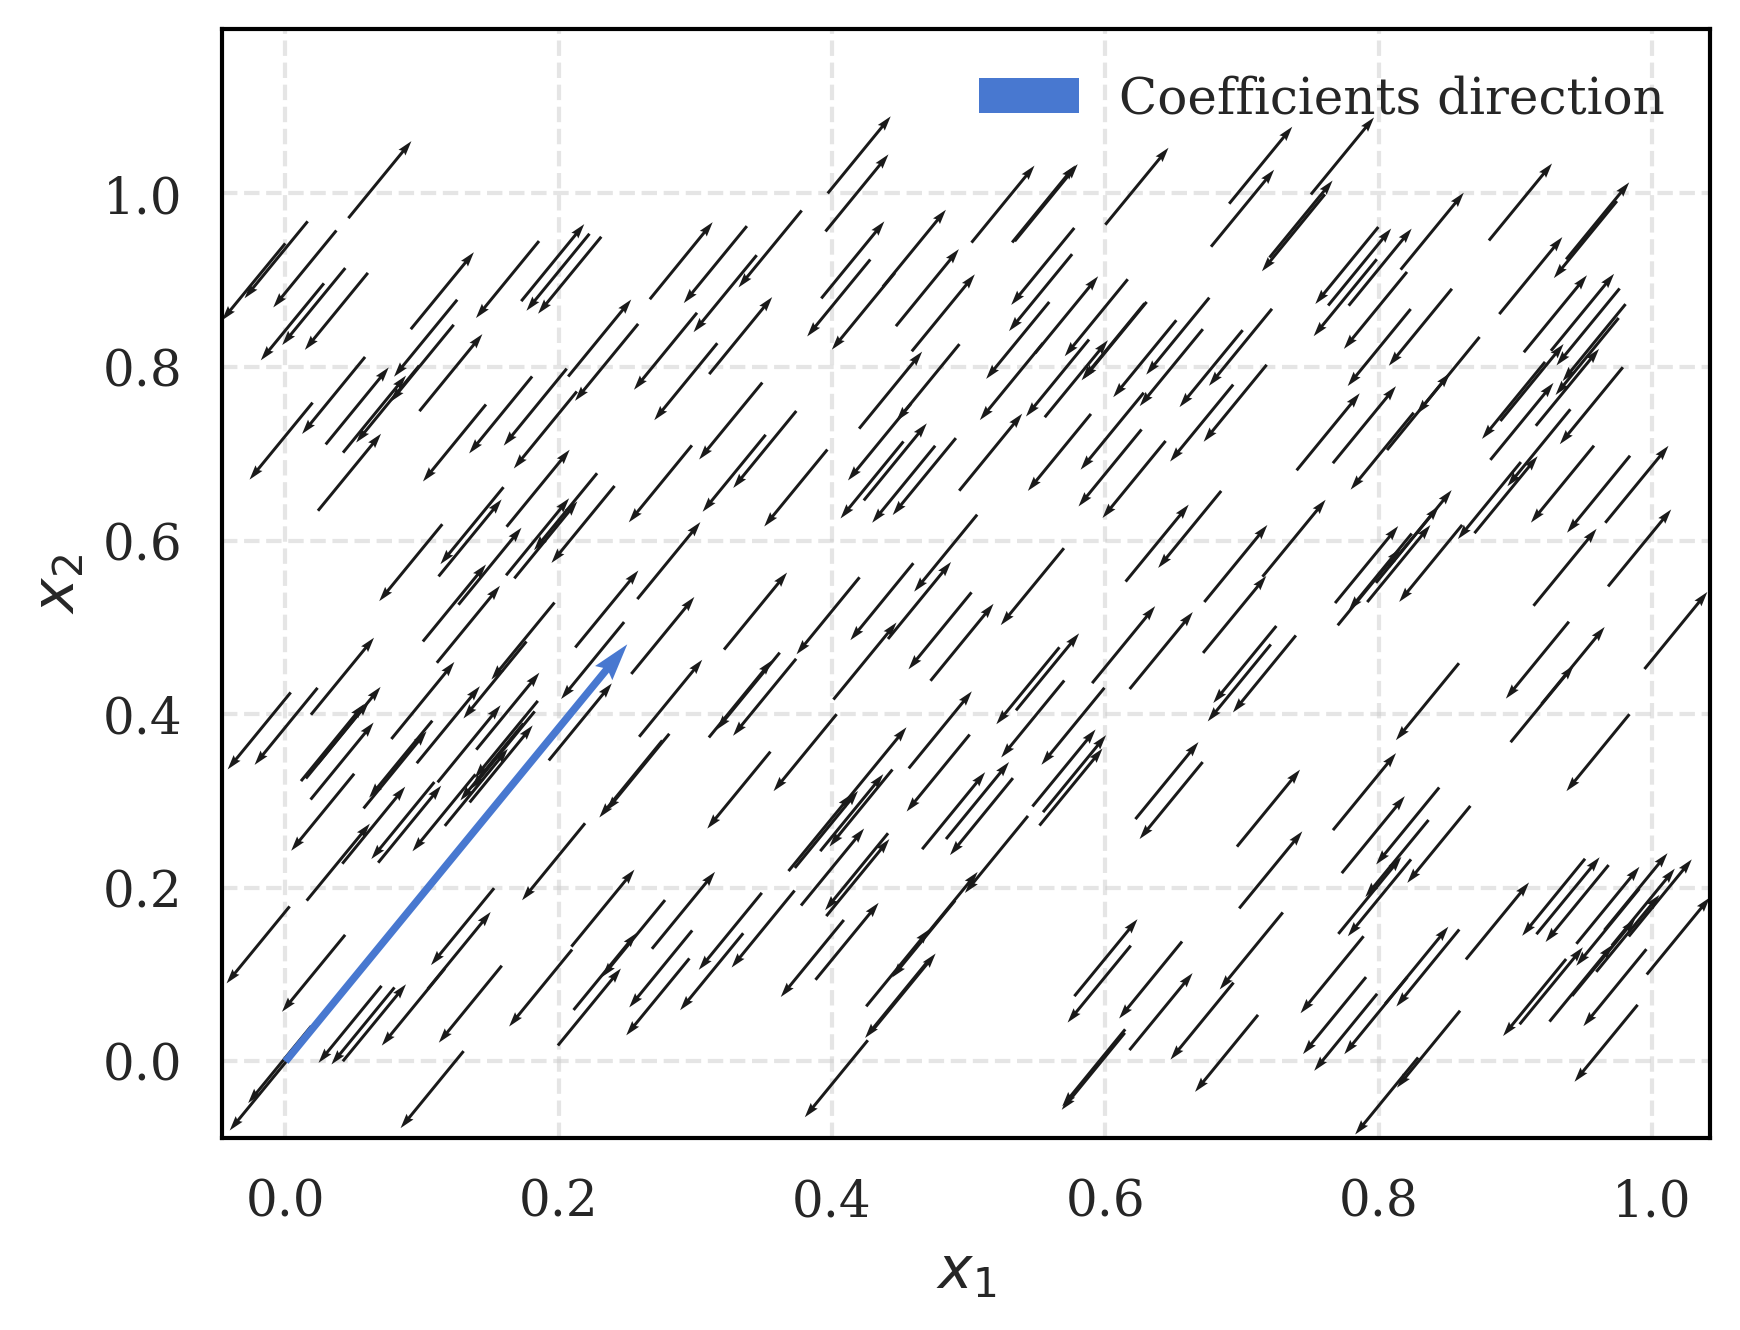

In [43]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * model.sigma2)
    x_adv, x_adv_values = mlmc_attack(model, x, lr=0.001)
    perturbations.append(x.clone().detach().numpy() - x_adv.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

## 4 Just backprop of E_y[ -\log \pi(y | x', D)] ? In theory biased

In [44]:
# queremos maximizar E_y[ -\log \pi(y | x', D)] ~ E_y[E_{Gamma|D}[-log \pi(y | x', Gamma)]] con y \sim p(y | x, D)

# Function to calculate kl proxy
def kl_proxy(model, x, x_adv, num_samples=100):
    y_samples = model.sample_predictive_distribution(x, num_samples=num_samples)
    return -torch.mean(torch.log(pi(y_samples, x_adv, model.sample_posterior_distribution(num_samples))))

def proxy_maximization(model, x, lr=0.01, n_iter=100, epsilon=.3, num_samples=100):
    x_adv_values = []
    proxy_values = []
    
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = SGD([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        proxy = - kl_proxy(model, x, x_adv, num_samples=num_samples)  # maximum disruption problem
        proxy.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        proxy_values.append(-proxy.detach().item())

    return x_adv.detach(), x_adv_values, proxy_values 

In [45]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

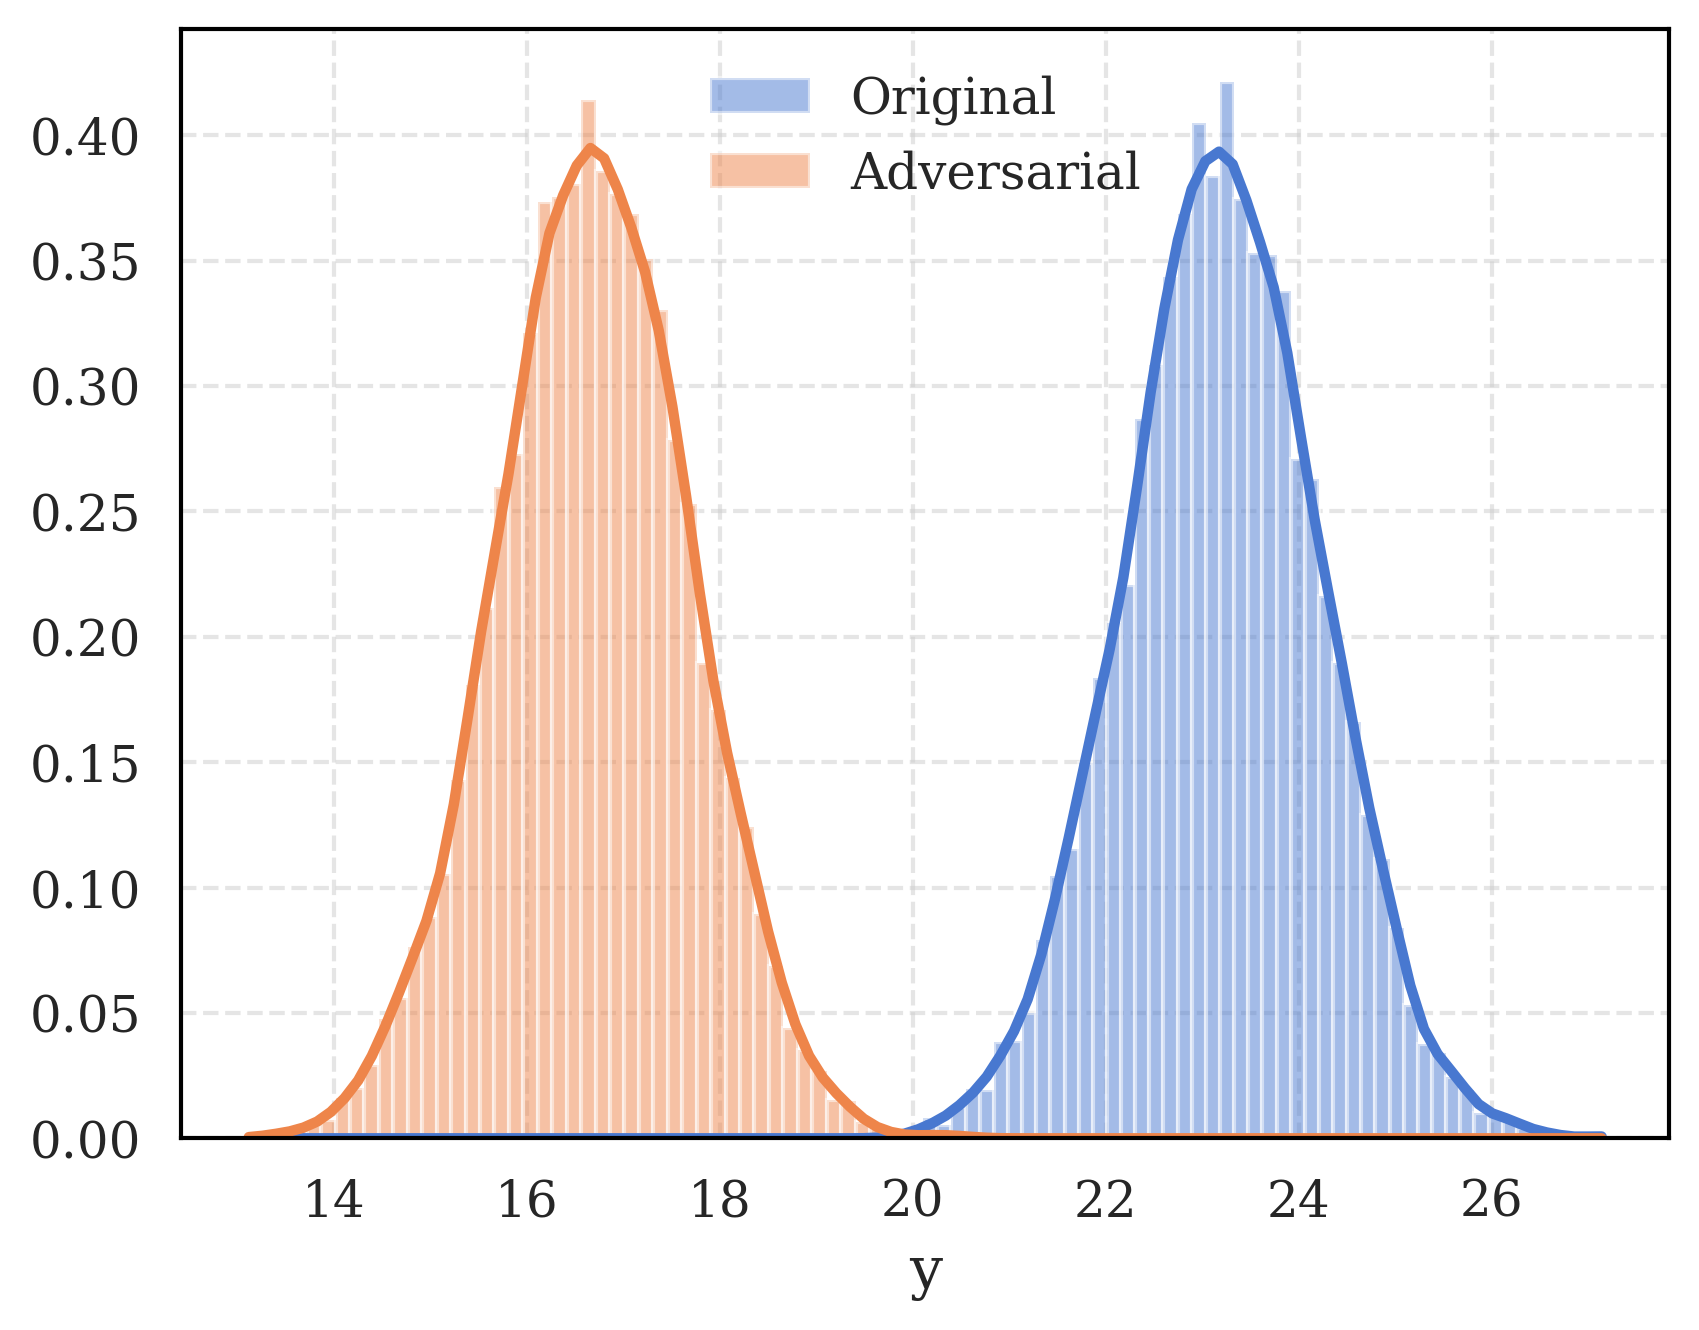

In [78]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_proxy, x_adv_values, proxy_values = proxy_maximization(model, x, epsilon=0.3, num_samples=100)
plot_ppds(model, x, x_adv_proxy)

#### Veamos que el gradiente esta sesgado

In [48]:
def proxy_gradient(model, x, num_samples=100):
    optimizer = SGD([x_adv], lr=0.0)
    x_adv.requires_grad = True
    optimizer.zero_grad()
    proxy = - kl_proxy(model, x, x_adv, num_samples=num_samples)  # maximum disruption problem
    proxy.backward()
    grad = x_adv.grad.clone().detach()
    x_adv.grad.zero_()

    return grad

In [49]:
X, y = get_toy_data()

In [50]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [51]:
# Model for which we know the true gradient
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [52]:
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

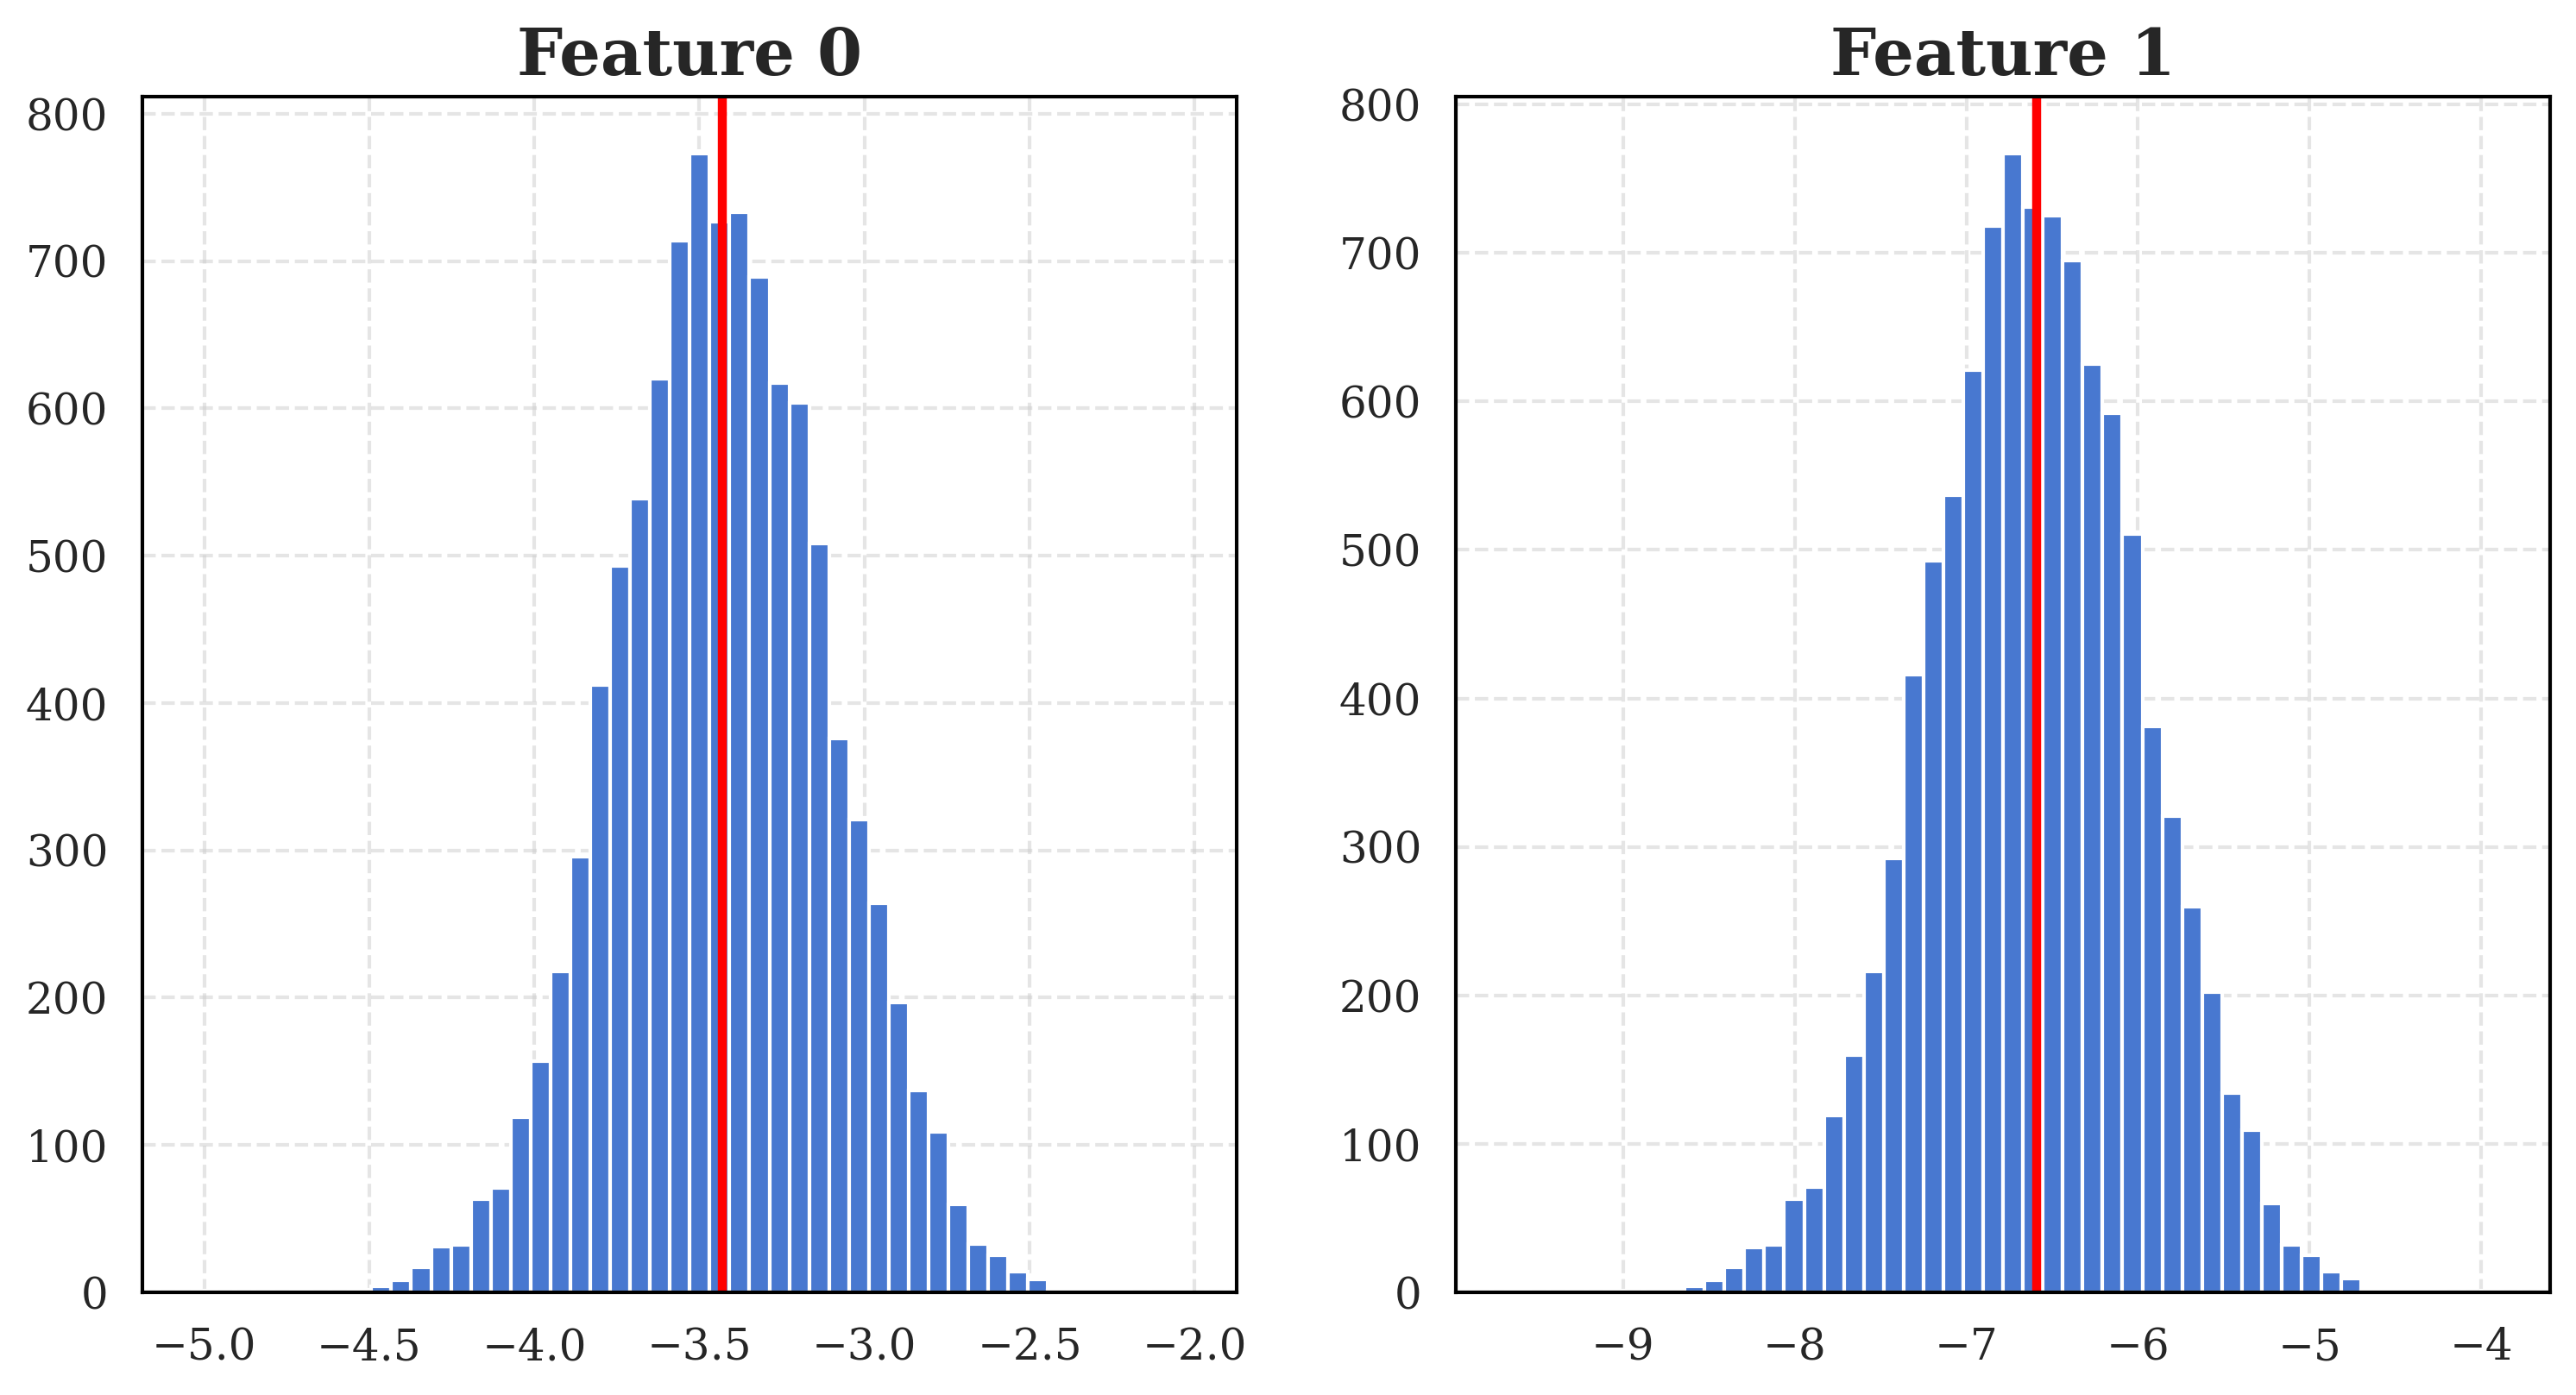

In [53]:
grads = []
for it in range(10000):
    grad = proxy_gradient(model, x, num_samples=1000)
    grads.append(grad)

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_title(f'Feature {i}')